In [5]:
import ee
from drought.data import ee_climate, pipeline
import drought.data.df_extensions as dfext
from drought.visualization import plot
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import importlib

## Prerequisites

Before running the notebook, make sure to authenticate with Google Earth 
Engine. 

You can do so by running ```earthengine authenticate``` on the command line
or uncommenting the authentication cell below. See [here](https://developers.google.com/earth-engine/guides/python_install#authentication) for more details.

### Earth Engine Initialization

In [ ]:
# Uncomment if you want to authenticate within jupyter notebook.
ee.Authenticate()

In [2]:
ee.Initialize()

## Get Climate Data

In [3]:
# Dates of interest.
start_date = ee.Date('2019-01-01')
end_date = ee.Date('2023-01-01')

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 5000

# Fetch climate data from Earth Engine as Pandas DataFrame.
climate_monthly_pdf = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale)

### Plot total monthly averages

In [5]:
# Calculate monthly mean for all three years in aggregate.
total_monthly_mean = climate_monthly_pdf.groupby(['month', 'polygon_id']) \
                                .mean(numeric_only=True).reset_index() \
                                .drop(columns=['year'])

In [ ]:
# Palette for plotting. Colors can be accessed by indexing - plot.palette[i]
plot.palette

In [ ]:
# Plot aggregate monthly precipitation per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='precipitation', 
                              ylabel="Precipitation mm / month",
                              title="Aggregate monthly precipitation per region 2019-2022",
                              color=plot.palette[5])
# Mark the 100mm precipitation line that signifies a dry month.
[subplot.axhline(y=100, color = 'r', linestyle = 'dotted', linewidth=3) 
 for subplot in fig.get_axes()]
plt.show()

In [ ]:
# Plot aggregate monthly radiation per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='radiation', 
                              ylabel="Radiation",
                              title="Mean monthly radiation per region 2019-2022",
                              color=plot.palette[0],
                              sharey=True)
plt.show()

In [ ]:
# Plot aggregate monthly temperature per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='temperature', 
                              ylabel="Temperature",
                              title="Mean monthly temperature per region 2019-2022",
                              color=plot.palette[7],
                              sharey=True)
plt.show()

In [ ]:
# Plot aggregate monthly fpar per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='fpar', 
                              ylabel="Fpar",
                              title="Mean monthly Fpar per region 2019-2022",
                              color=plot.palette[3],
                              sharey=True)
plt.show()

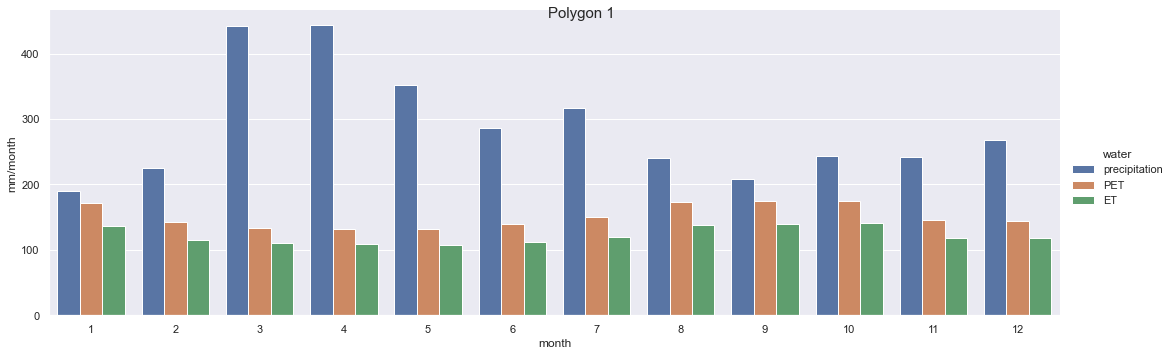

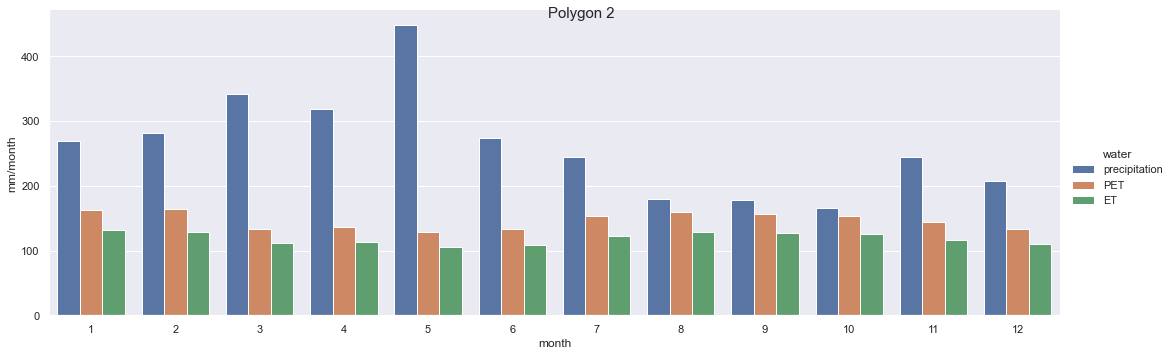

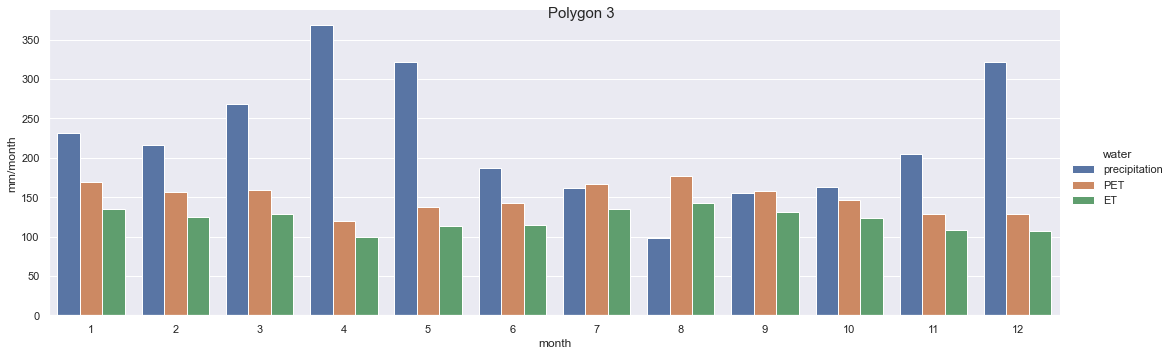

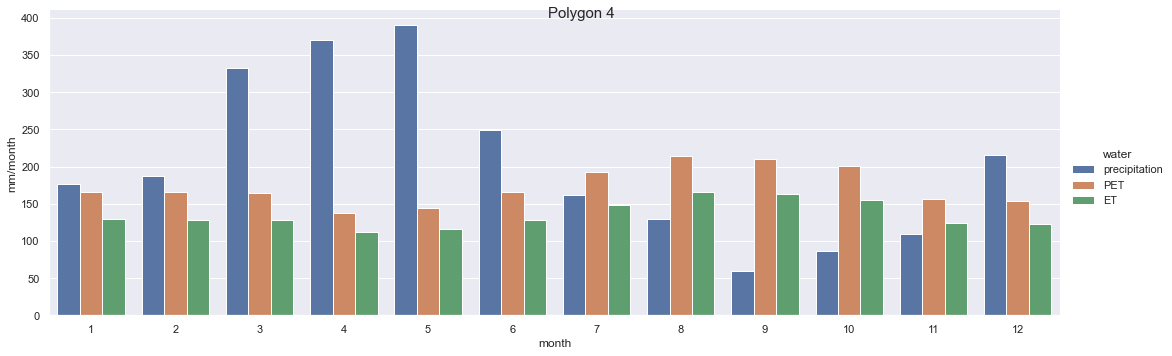

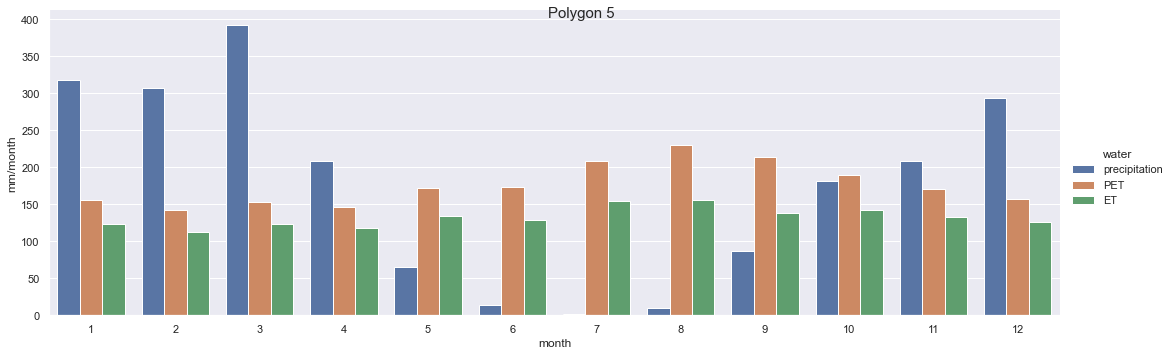

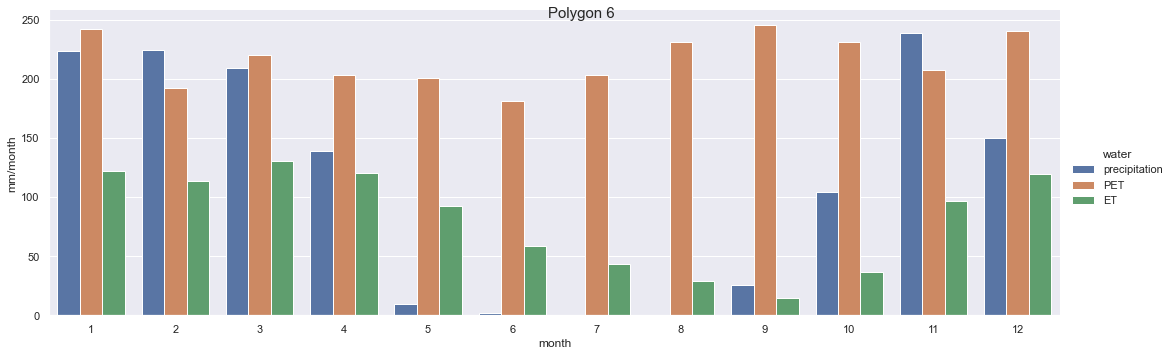

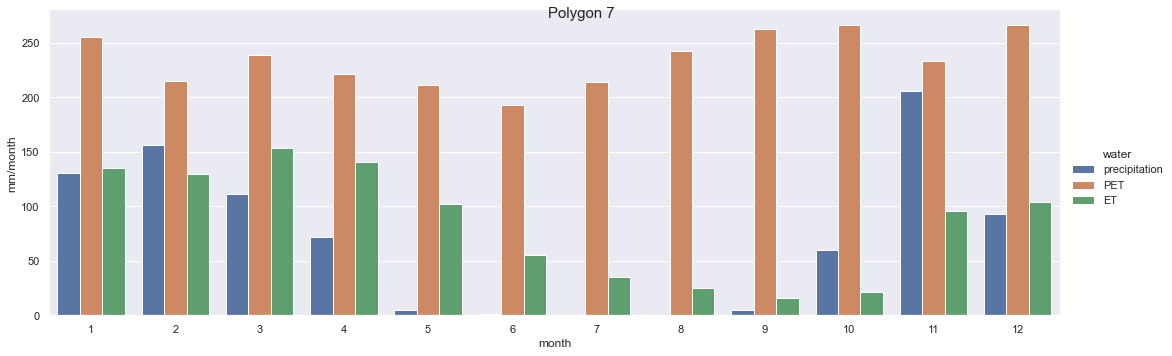

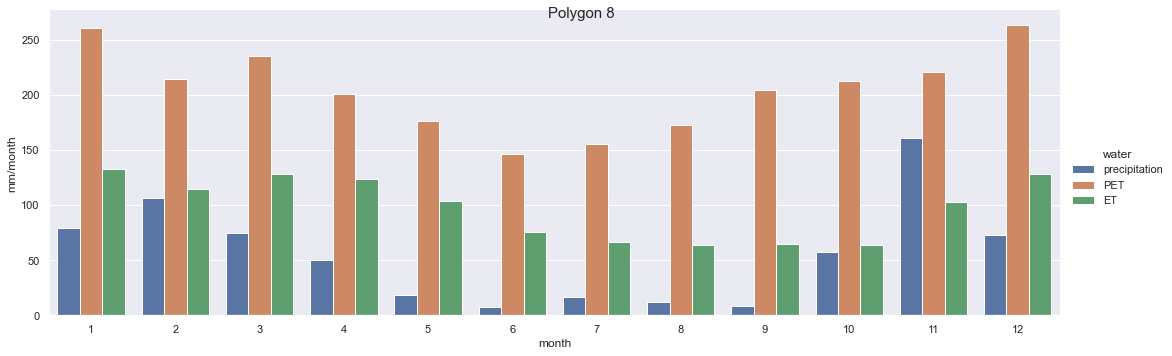

In [7]:
fig = plot.catplot_per_polygon(total_monthly_mean, 'month', 'mm/month', 'water', 'bar', ['precipitation', 'PET', 'ET'], title="bla")
plt.show()

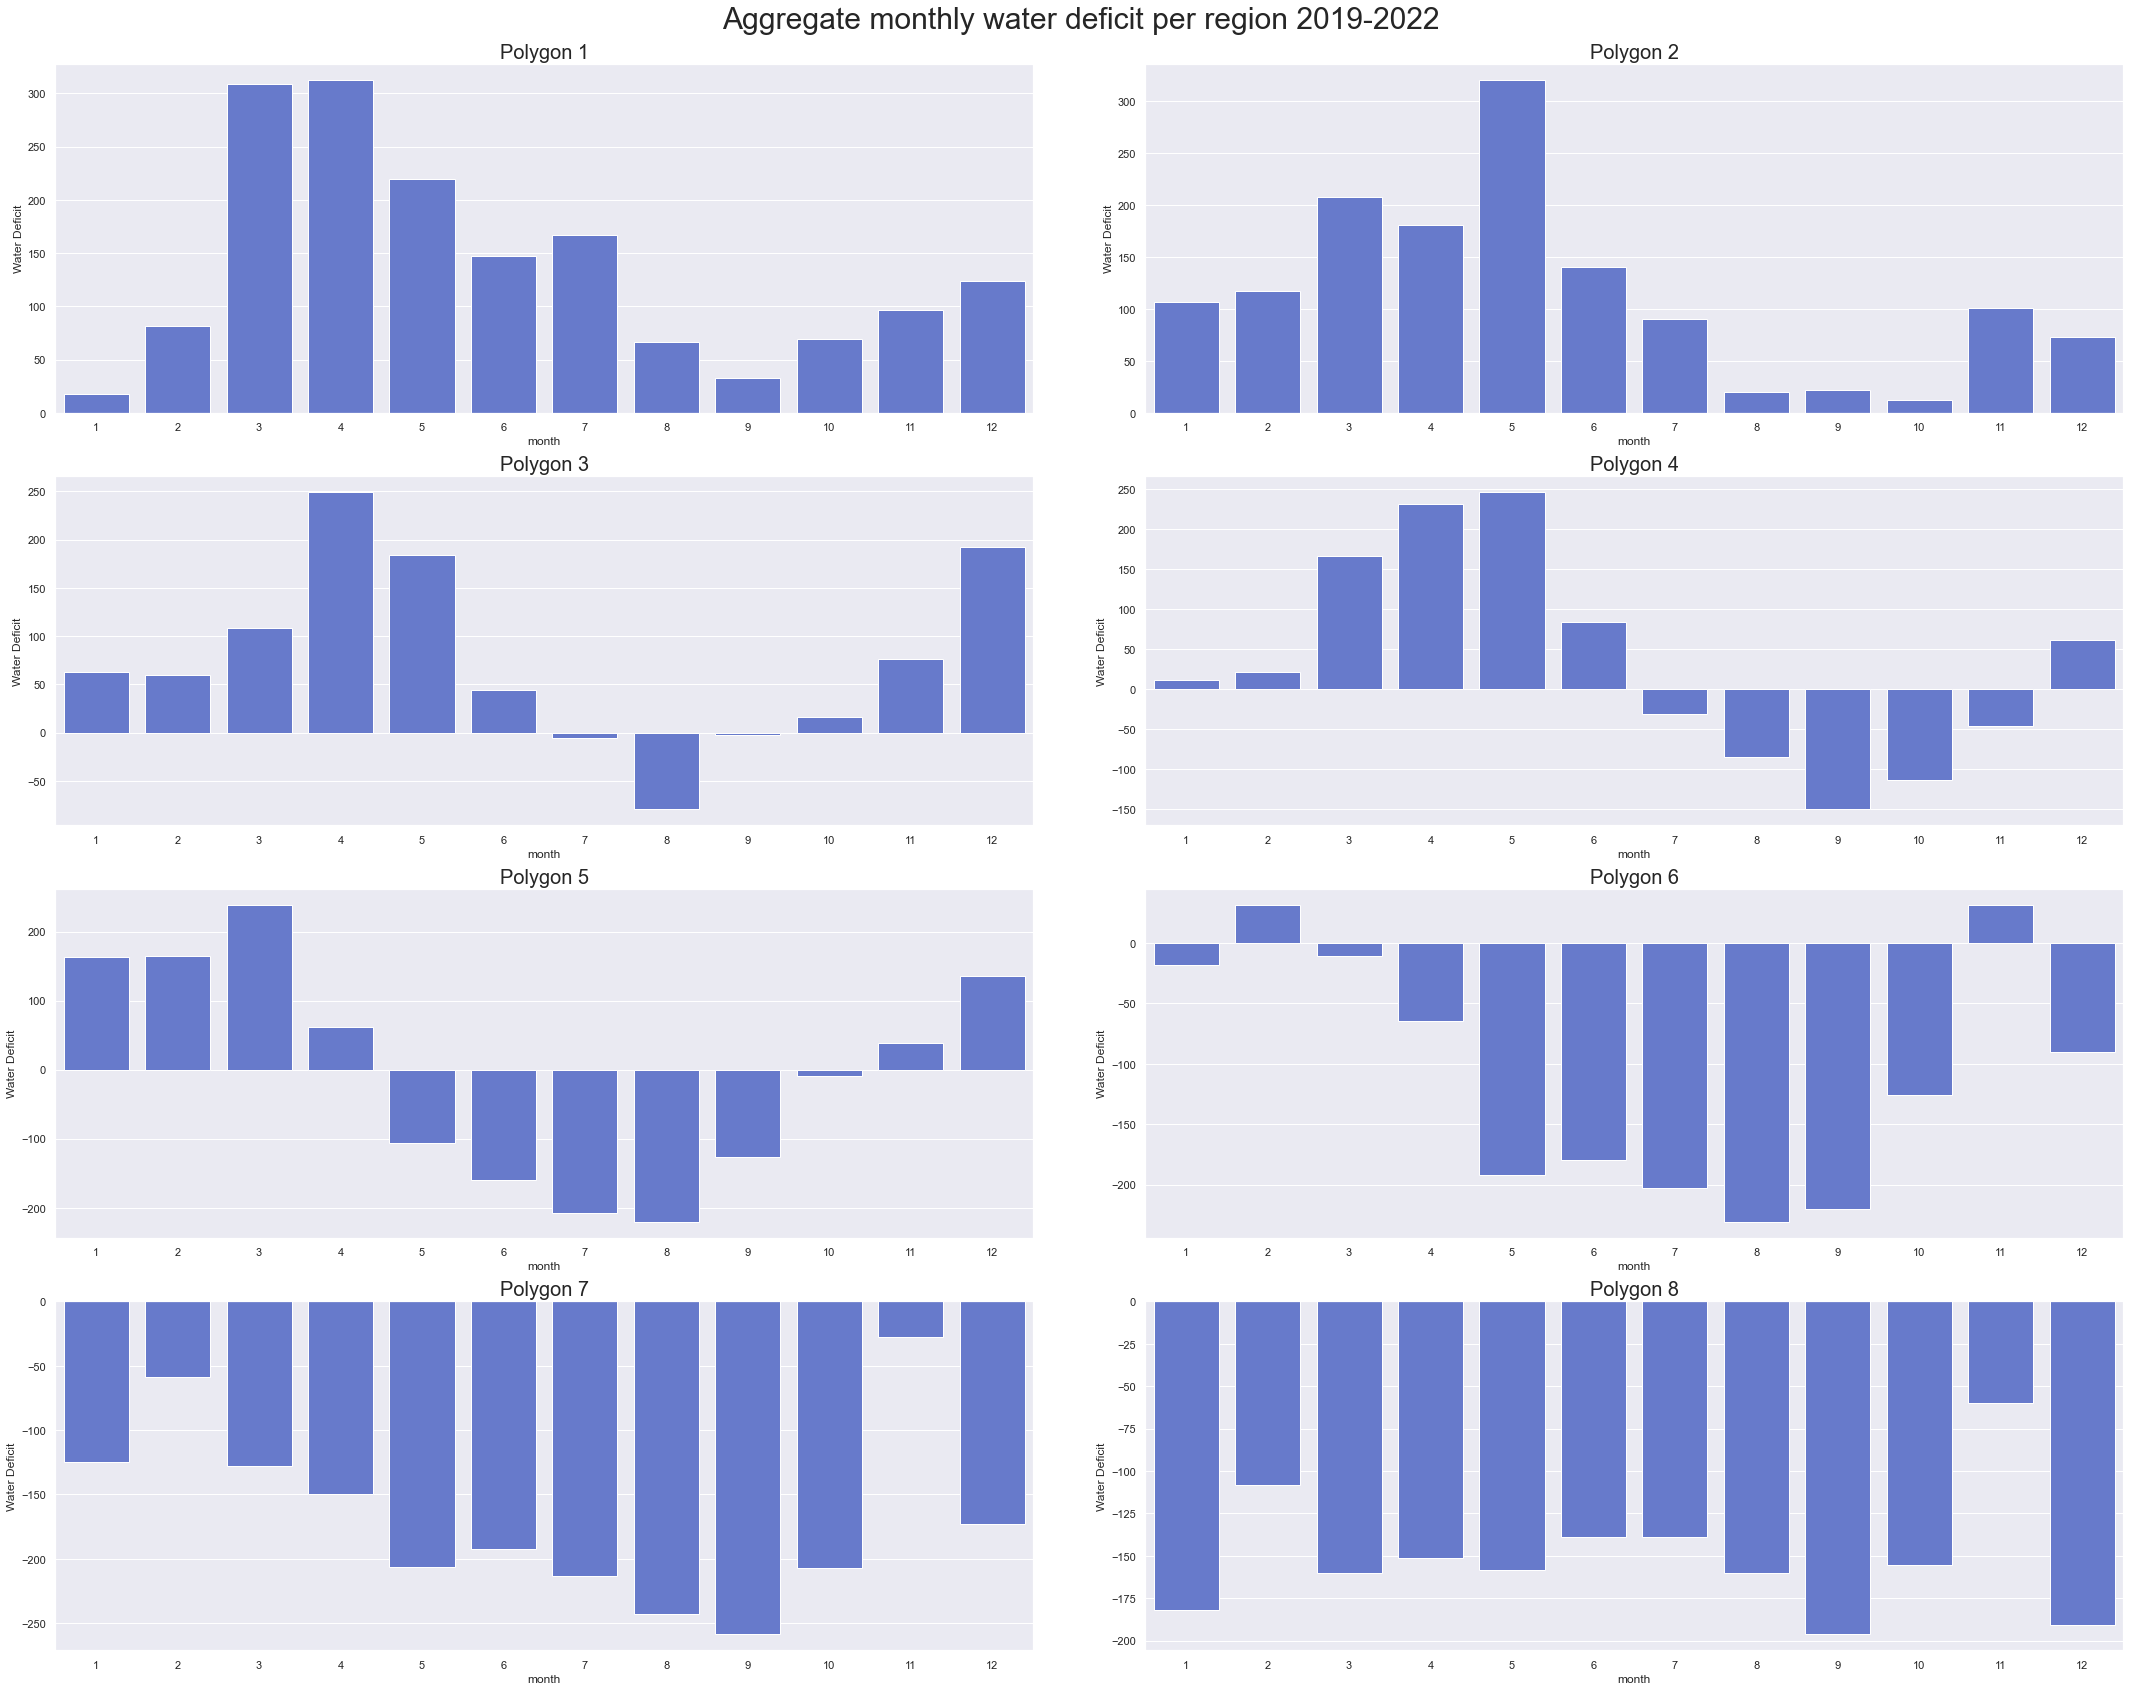

In [6]:
# Water deficit
total_monthly_mean['water_deficit'] = total_monthly_mean['precipitation'] - total_monthly_mean['PET']
# Plot aggregate monthly potential evapotranspiration per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='water_deficit', 
                              ylabel="Water Deficit",
                              title="Aggregate monthly water deficit per region 2019-2022",
                              color=plot.palette[5])

plt.savefig(f'../../reports/figures/exploratory/total_monthly_water_deficit_2019_to_2022.png')
plt.show()

### Fetch and Save Climate Data for 2010-2022

In [2]:
# Dates of interest.
start_date_str = '2010-01-01'
end_date_str = '2022-11-01'

In [ ]:
# Dates of interest.
start_date = ee.Date(start_date_str)
end_date = ee.Date(end_date_str)

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 5000

# NOTE: we partitioned the data fetch in two because otherwise we go over
# the Earth Engine limit, so we need to chunk.

# Fetch water-related variables.
precip_df = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['precipitation', 'ET', 'PET'])

# Fetch other climate variables
radiation_pdf = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['temperature', 'radiation', 'fpar'])

In [ ]:
precip_monthly_mean = precip_df.groupby(['month', 'polygon_id', 'year']) \
                               .mean(numeric_only=True).reset_index()
precip_monthly_mean = dfext.add_datetime_column(precip_monthly_mean)
precip_monthly_mean = dfext.add_date_column(precip_monthly_mean)
precip_monthly_mean['P-PET'] = precip_monthly_mean['precipitation'] - precip_monthly_mean['PET']
precip_monthly_mean['P-ET'] = precip_monthly_mean['precipitation'] - precip_monthly_mean['ET']

In [ ]:
radiation_monthly_mean = radiation_pdf.groupby(['month', 'polygon_id', 'year']) \
                                      .mean(numeric_only=True).reset_index()
radiation_monthly_mean = dfext.add_datetime_column(radiation_monthly_mean)
radiation_monthly_mean = dfext.add_date_column(radiation_monthly_mean)

In [ ]:
precip_monthly_mean.to_csv('../../data/interim/monthly_means_timeseries_of_water_climate_vars_01-2010_to_11-2022.csv')
radiation_monthly_mean.to_csv('../../data/interim/monthly_means_timeseries_of_radiation_vars_01-2010_to_11-2022.csv')

In [ ]:
# Join all climate vars.
climate_df = precip_monthly_mean.set_index(['month', 'polygon_id', 'year', 'datetime', 'date']) \
                                .join(radiation_monthly_mean.set_index(['month', 'polygon_id', 'year', 'datetime', 'date'])) \
                                .reset_index()

In [ ]:
climate_df.to_csv('../../data/interim/monthly_means_timeseries_of_climate_vars_01-2010_to_11-2022.csv')

### Fetch and Save Water Balance Data for 2001-2022

In [3]:
# Dates of interest.
start_date_str = '2001-01-01'
end_date_str = '2023-01-01'

In [ ]:
# Dates of interest.
start_date = ee.Date(start_date_str)
end_date = ee.Date(end_date_str)

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 50000

# Fetch climate data from Earth Engine as Pandas DataFrame.
precip_df = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['precipitation', 'PET'])

In [ ]:
precip_df.to_csv('../../data/interim/p_pet_2001-2023_scale_50km.csv')

In [7]:
precip_df = pd.read_csv('../../data/interim/p_pet_2001-2023_scale_50km.csv', index_col=0)

### Calculate and visualize Water Balance

From the "Spanish" paper: "An absolute measure of yearly climatic water balance was computed for each site to evaluate the effect of the latitudinal climatic gradient on forest response to drought. It corresponds to monthly precipitation minus potential evapotranspiration averaged across the 18 years."

In [9]:
# Calculate monthly water balance
precip_df['P-PET'] = precip_df.precipitation - precip_df.PET

In [14]:
# Calculate yearly averages
yearly_means = precip_df.groupby(['longitude', 'latitude', 'polygon_id', 'year']).mean(numeric_only=True).reset_index()

In [58]:
# Calculate yearly averages across 22 years
total_yearly_means = yearly_means.groupby(['longitude', 'latitude', 'polygon_id']).mean(numeric_only=True).reset_index().round(2)\
.sort_values('latitude', ascending=False).sort_values('longitude')

In [60]:
recent_yearly_means =yearly_means[yearly_means.year>=2019].groupby(['longitude', 'latitude', 'polygon_id']).mean(numeric_only=True).reset_index().round(2)\
.sort_values('latitude', ascending=False).sort_values('longitude')

In [27]:
import altair as alt

In [59]:
for polygon_id in range(1, 9):
    print(polygon_id)
    polygon_data = total_yearly_means[total_yearly_means.polygon_id==polygon_id]
    min = polygon_data['P-PET'].min()
    max = polygon_data['P-PET'].max()
    chart = alt.Chart(total_yearly_means[total_yearly_means.polygon_id==polygon_id]).mark_rect().encode(
        x='longitude:O',
        y= alt.Y('latitude:O', sort="descending"),
        color=alt.Color(
            'mean(P-PET):Q', scale=alt.Scale(scheme='redblue', domain=(min, max))),
        tooltip=[
            alt.Tooltip('longitude:O', title='Year'),
            alt.Tooltip('latitude:O', title='Month'),
            alt.Tooltip('mean(P-PET):Q', title='PDSI')
        ]).properties(width=300, height=300)
    chart.display()

1


alt.Chart(...)

2


alt.Chart(...)

3


alt.Chart(...)

4


alt.Chart(...)

5


alt.Chart(...)

6


alt.Chart(...)

7


alt.Chart(...)

8


alt.Chart(...)

In [61]:
for polygon_id in range(1, 9):
    print(polygon_id)
    polygon_data = recent_yearly_means[recent_yearly_means.polygon_id==polygon_id]
    min = polygon_data['P-PET'].min()
    max = polygon_data['P-PET'].max()
    chart = alt.Chart(polygon_data).mark_rect().encode(
        x='longitude:O',
        y= alt.Y('latitude:O', sort="descending"),
        color=alt.Color(
            'mean(P-PET):Q', scale=alt.Scale(scheme='redblue', domain=(min, max))),
        tooltip=[
            alt.Tooltip('longitude:O', title='Year'),
            alt.Tooltip('latitude:O', title='Month'),
            alt.Tooltip('mean(P-PET):Q', title='PDSI')
        ]).properties(width=300, height=300)
    chart.display()

1


alt.Chart(...)

2


alt.Chart(...)

3


alt.Chart(...)

4


alt.Chart(...)

5


alt.Chart(...)

6


alt.Chart(...)

7


alt.Chart(...)

8


alt.Chart(...)

### Get Aggregate water climatic balanse per polygon

recent_yearly_means =yearly_means[yearly_means.year>=2019].groupby(['longitude', 'latitude', 'polygon_id']).mean(numeric_only=True).reset_index().round(2)\
.sort_values('latitude', ascending=False).sort_values('longitude')

[Text(0.5, 1.0, '20 year avg water balance with Spatial and temporal variation within each polygon')]

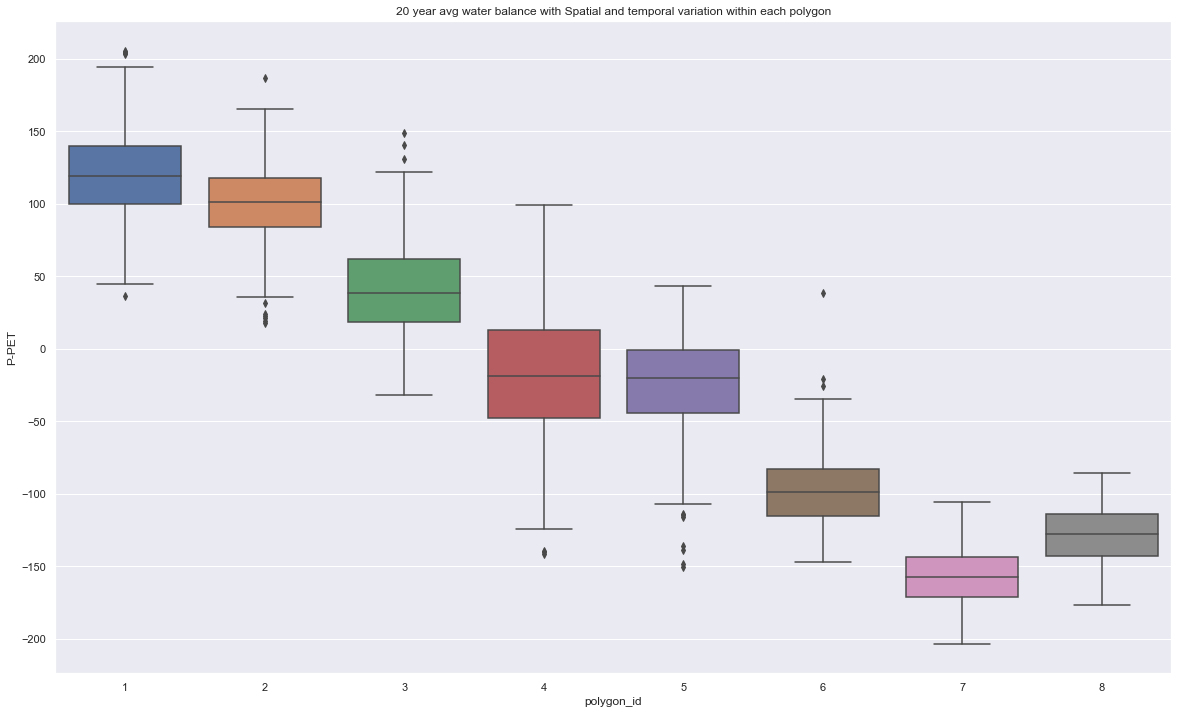

In [73]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [20, 12]

# Shows both time and space variance
sns.boxplot(yearly_means, x='polygon_id', y='P-PET').set(title="20 year avg water balance with Spatial and temporal variation within each polygon")

[Text(0.5, 1.0, '20 year avg water balance with Spatial variation within each polygon')]

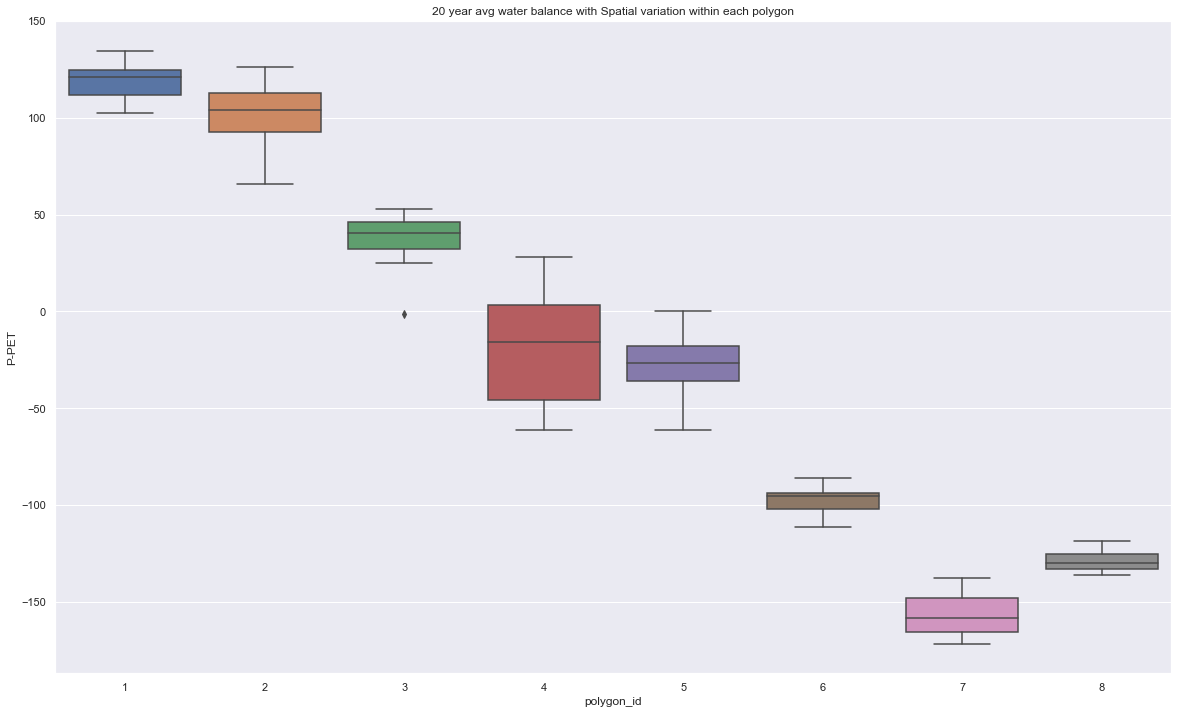

In [71]:
sns.boxplot(yearly_means.groupby(['longitude', 'latitude', 'polygon_id']).mean().reset_index(), x='polygon_id', y='P-PET').set(title='20 year avg water balance with Spatial variation within each polygon')

Text(0.5, 1.0, 'Annual Average Water Balance per Polygon')

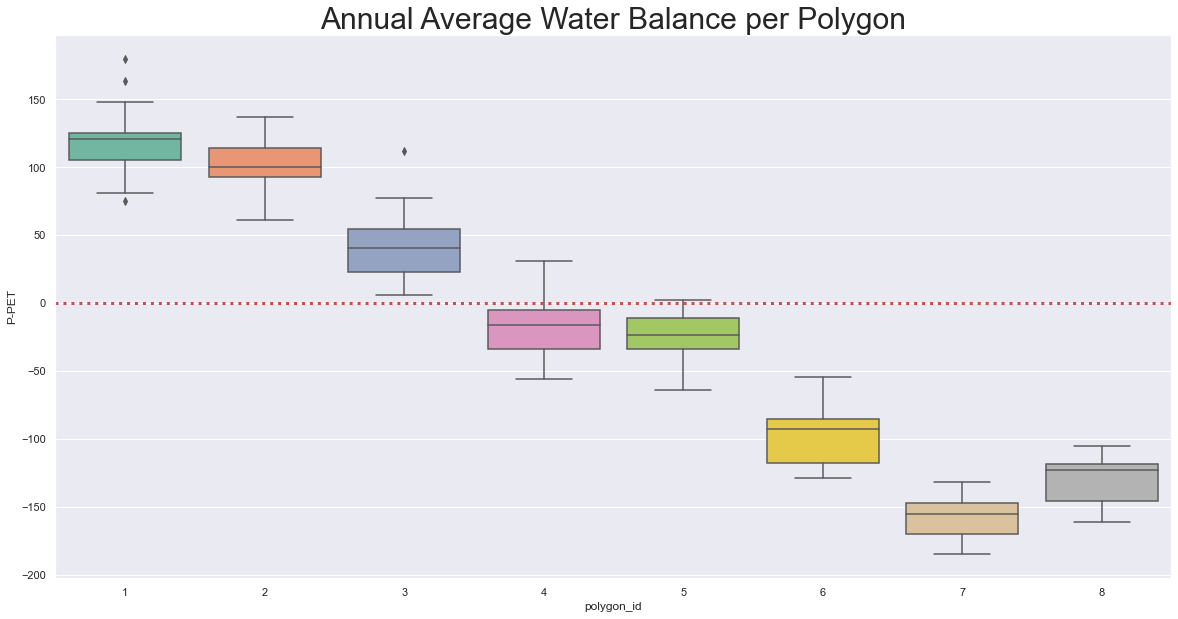

In [115]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(yearly_means.groupby(['year', 'polygon_id']).mean().reset_index(), x='polygon_id', y='P-PET', ax=ax, palette=sns.color_palette("Set2"))
ax.axhline(y = 0, color = 'r', linestyle = 'dotted', linewidth=3)
ax.axes.set_title('Annual Average Water Balance per Polygon', fontsize=30)

Text(0.5, 1.0, 'Annual Average Water Balance')

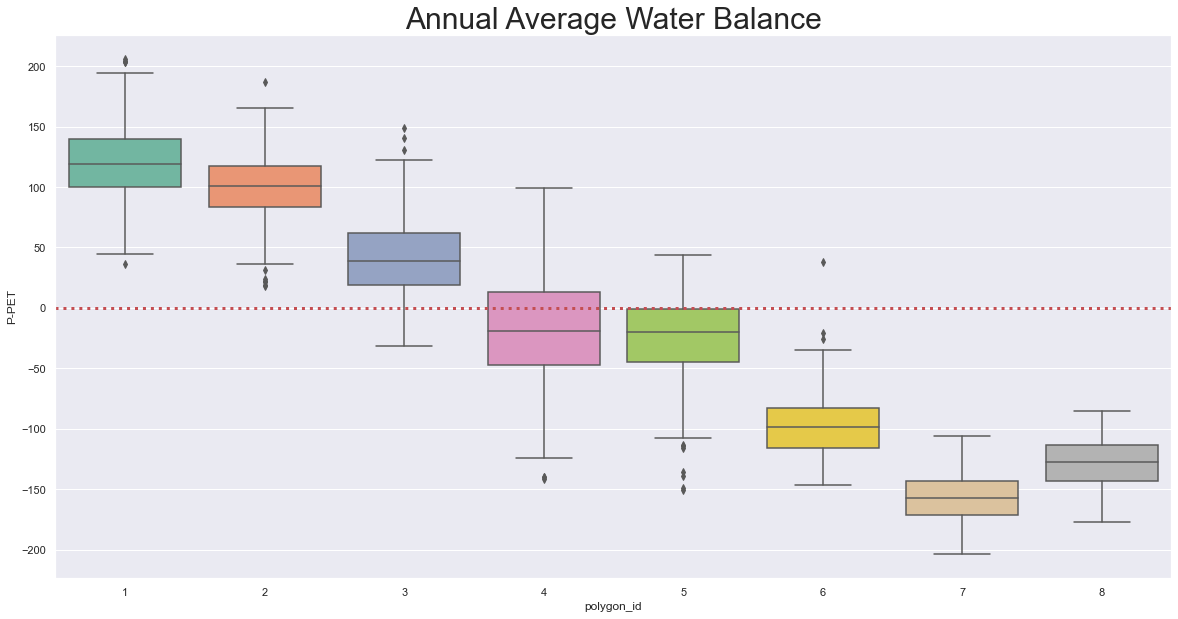

In [122]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(yearly_means, x='polygon_id', y='P-PET', ax=ax, palette=sns.color_palette("Set2"))
ax.axhline(y = 0, color = 'r', linestyle = 'dotted', linewidth=3)
ax.axes.set_title('Annual Average Water Balance', fontsize=30)

In [87]:
yearly_means.groupby(['polygon_id']).mean().reset_index()

,polygon_id,longitude,latitude,year,time,month,precipitation,PET,P-PET
0,1,-73.661853,-1.347473,2011.500000,1.324900e+12,6.827946,272.266852,152.485588,119.781264
1,2,-66.924489,-0.449158,2011.500000,1.324456e+12,6.660104,249.875800,148.489786,101.386014
2,3,-61.128184,-2.203044,2011.531722,1.325742e+12,6.769602,193.424403,152.234662,41.189742
3,4,-56.144705,0.000000,2011.500000,1.325983e+12,7.241576,168.024264,186.177557,-18.153294
4,5,-53.043346,-8.519747,2011.531722,1.325356e+12,6.624740,151.339458,176.491425,-25.151967
5,6,-48.059868,-13.025572,2011.500000,1.323988e+12,6.483118,117.176951,214.398818,-97.221867
6,7,-44.466607,-11.228941,2011.500000,1.324022e+12,6.495558,73.652525,231.225338,-157.572813
7,8,-41.322503,-16.618833,2011.500000,1.323994e+12,6.485072,71.810090,200.640075,-128.829986


Text(0.5, 1.0, 'Average Monthly Precipitation per Polygon')

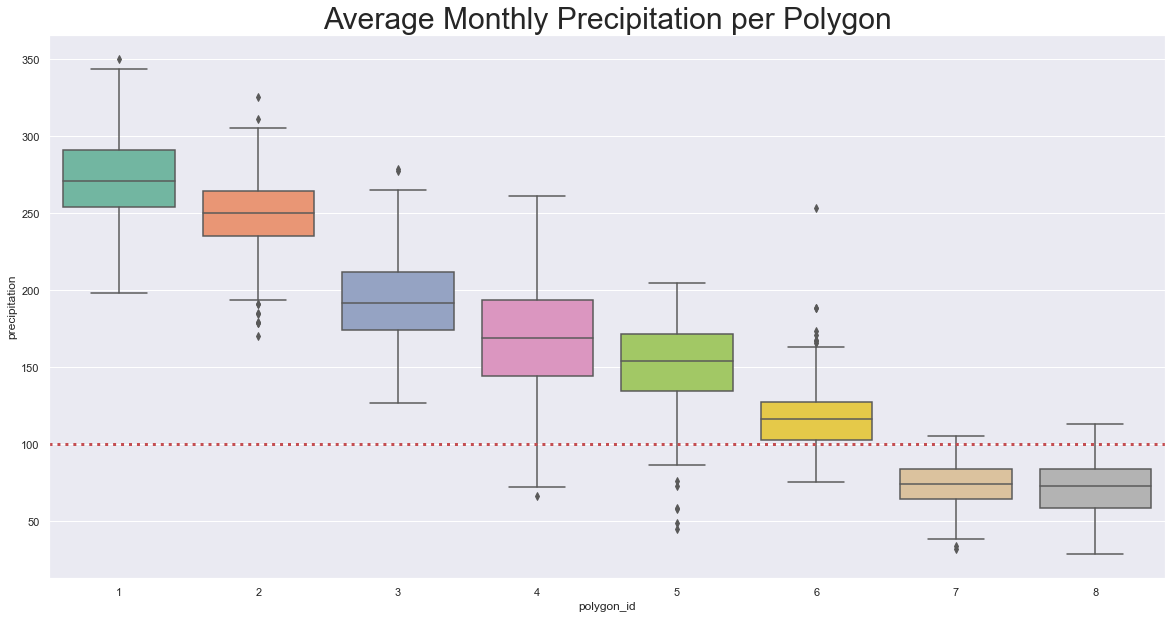

In [119]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(yearly_means, x='polygon_id', y='precipitation', ax=ax, palette=sns.color_palette("Set2"))
ax.axhline(y = 100, color = 'r', linestyle = 'dotted', linewidth=3)
ax.axes.set_title('Average Monthly Precipitation per Polygon', fontsize=30)

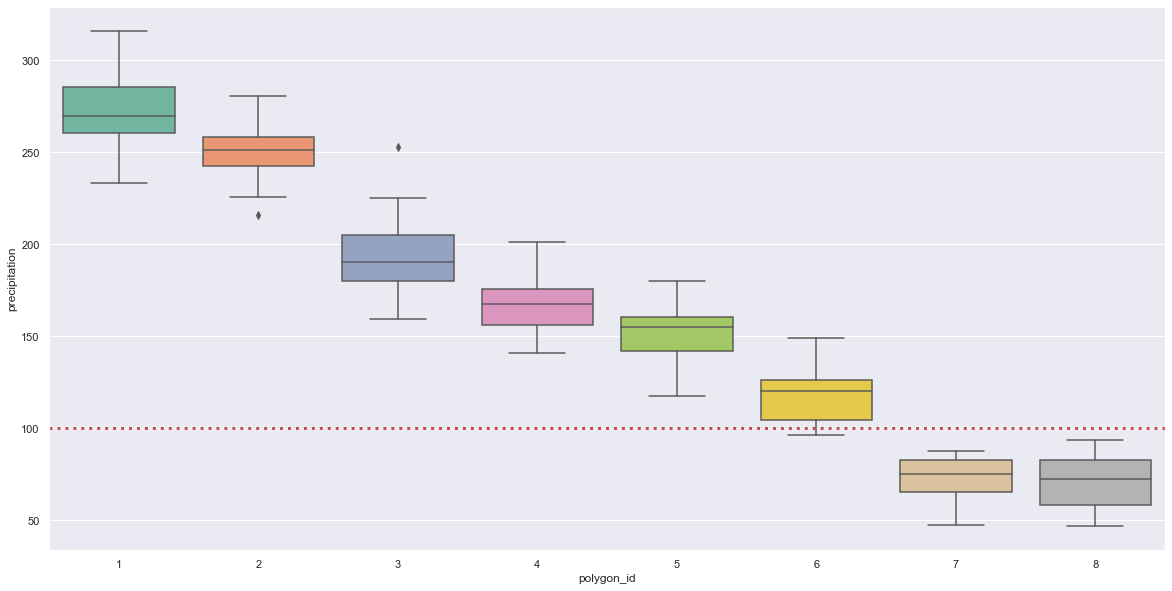

In [358]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(yearly_means.groupby(['year', 'polygon_id']).mean().reset_index(), x='polygon_id', y='precipitation', ax=ax, palette=sns.color_palette("Set2"))
ax.axhline(y = 100, color = 'r', linestyle = 'dotted', linewidth=3)
#ax.axes.set_title('Average Monthly Precipitation per Polygon', fontsize=30)

### Plot PAI

In [198]:
interpolated_gedi = pd.read_csv('../../data/interim/gedi_monthly_interpolated_via_weighted_average.csv', index_col=0).dropna()
interpolated_gedi

,pai,rh100,year,month,polygon_id,number,date,pai_interpolated
8,3.766817,2731.935935,2019,5,1,26114,05-19,3.798004
16,3.913649,2847.959920,2019,6,1,44411,06-19,3.743782
24,3.608399,2711.856065,2019,7,1,60166,07-19,3.785950
32,3.973964,2822.755271,2019,8,1,26654,08-19,3.748627
40,3.786409,2815.184880,2019,9,1,64339,09-19,3.738078
...,...,...,...,...,...,...,...,...
261,1.597032,1386.197647,2022,1,8,32973,01-22,1.567903
269,1.515809,1297.919529,2022,2,8,17149,02-22,1.535354
277,1.382222,1234.216282,2022,3,8,11092,03-22,1.489077
285,1.531108,1323.186849,2022,4,8,17292,04-22,1.453952


In [123]:
monthly_data = pipeline.get_monthly_means_per_polygon()

Text(0.5, 1.0, 'Average Monthly Plant Area Index')

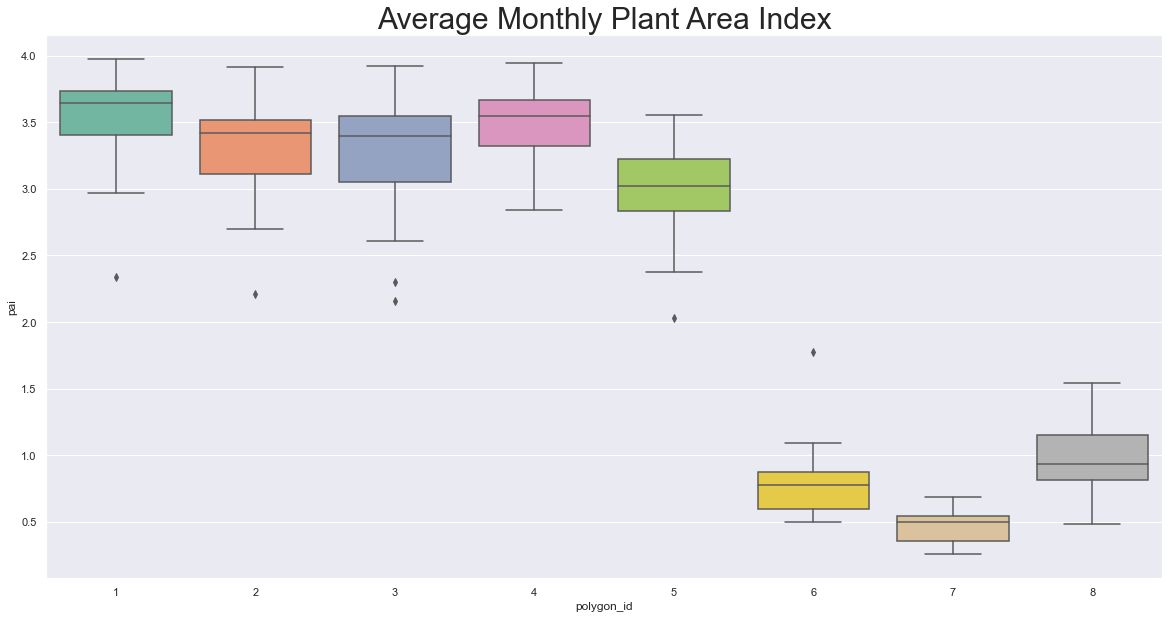

In [127]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(monthly_data, x='polygon_id', y='pai', ax=ax, palette=sns.color_palette("Set2"))
ax.axes.set_title('Average Monthly Plant Area Index', fontsize=30)

<AxesSubplot: xlabel='polygon_id', ylabel='pai_interpolated'>

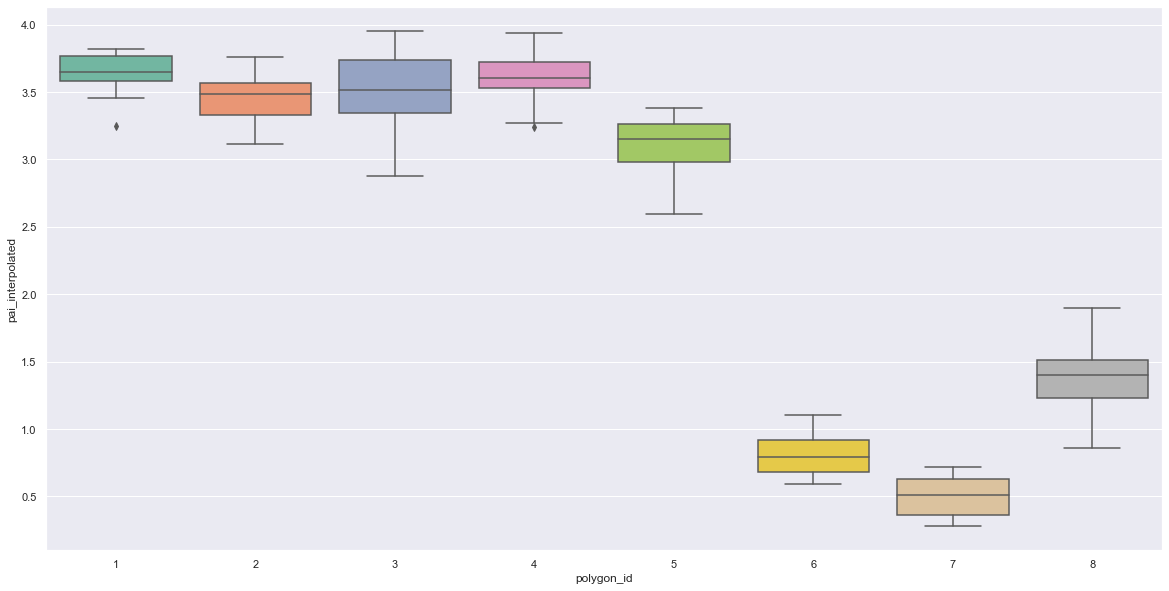

In [357]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(interpolated_gedi, x='polygon_id', y='pai_interpolated', ax=ax, palette=sns.color_palette("Set2"))

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/2896376926.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pai_cv = ((monthly_data.groupby('polygon_id').std().pai / monthly_data.groupby('polygon_id').mean().pai) * 100).reset_index()
/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/2896376926.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pai_cv = ((monthly_data.groupby('polygon_id').std().pai / monthly_data.groupby('polygon_id').mean().pai) * 100).reset_index()


Text(0.5, 1.0, 'Coefficient of Variation of Plant Area Index')

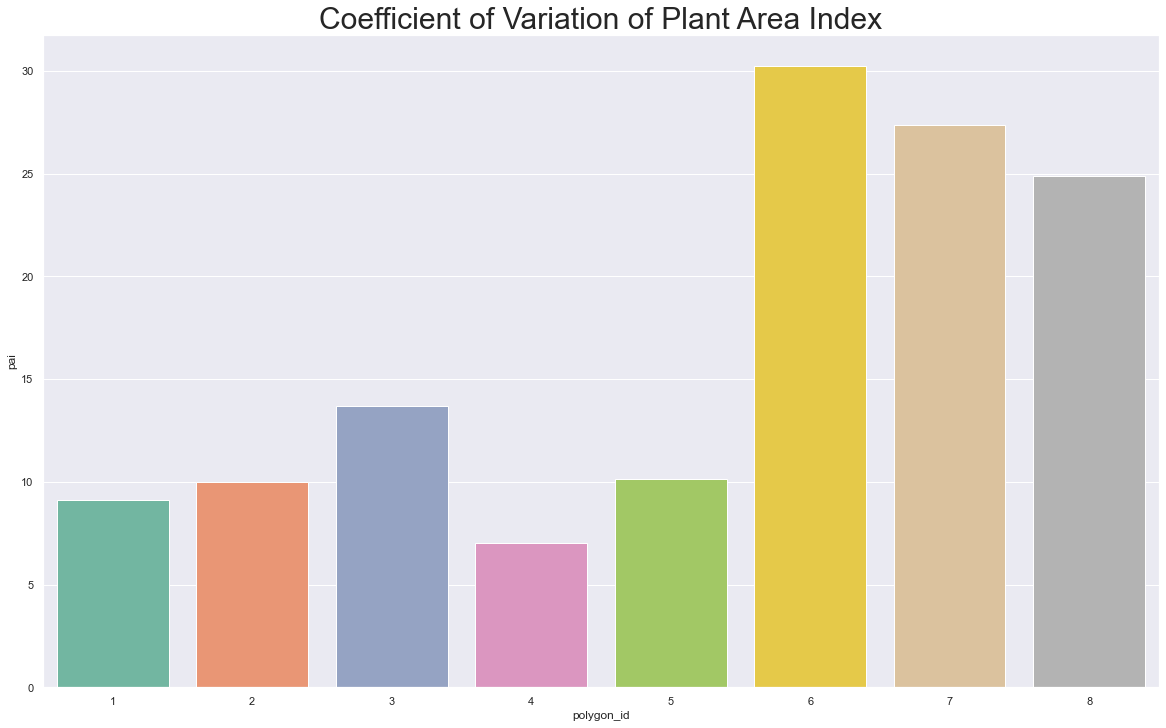

In [203]:
pai_cv = ((monthly_data.groupby('polygon_id').std().pai / monthly_data.groupby('polygon_id').mean().pai) * 100).reset_index()
ax = sns.barplot(pai_cv, x='polygon_id', y='pai', palette=sns.color_palette("Set2"))
ax.axes.set_title('Coefficient of Variation of Plant Area Index', fontsize=30)

In [148]:
monthly_data

,month,year,polygon_id,pai,precipitation,temperature,radiation
0,1,2020,1,3.676017,111.927796,30.139926,1.533163e+07
1,1,2020,2,3.368554,196.966859,28.646051,1.516526e+07
2,1,2020,3,2.606483,158.619501,29.270302,1.568071e+07
3,1,2020,4,3.794207,125.071252,27.873457,1.435729e+07
4,1,2020,5,3.301465,292.113777,27.333688,1.424309e+07
...,...,...,...,...,...,...,...
294,12,2021,4,3.087010,329.821745,27.801845,1.333075e+07
295,12,2021,5,2.885736,337.831219,27.371466,1.159784e+07
296,12,2021,6,0.806422,466.951728,29.931494,1.140797e+07
297,12,2021,7,0.585766,299.846644,30.686953,1.371934e+07


/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/2632115670.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pai_cv = ((interpolated_gedi.groupby('polygon_id').std().pai_interpolated / interpolated_gedi.groupby('polygon_id').mean().pai_interpolated) * 100).reset_index()
/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/2632115670.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pai_cv = ((interpolated_gedi.groupby('polygon_id').std().pai_interpolated / interpolated_gedi.groupby('polygon_id').mean().pai_interpolated) * 100).reset_index()


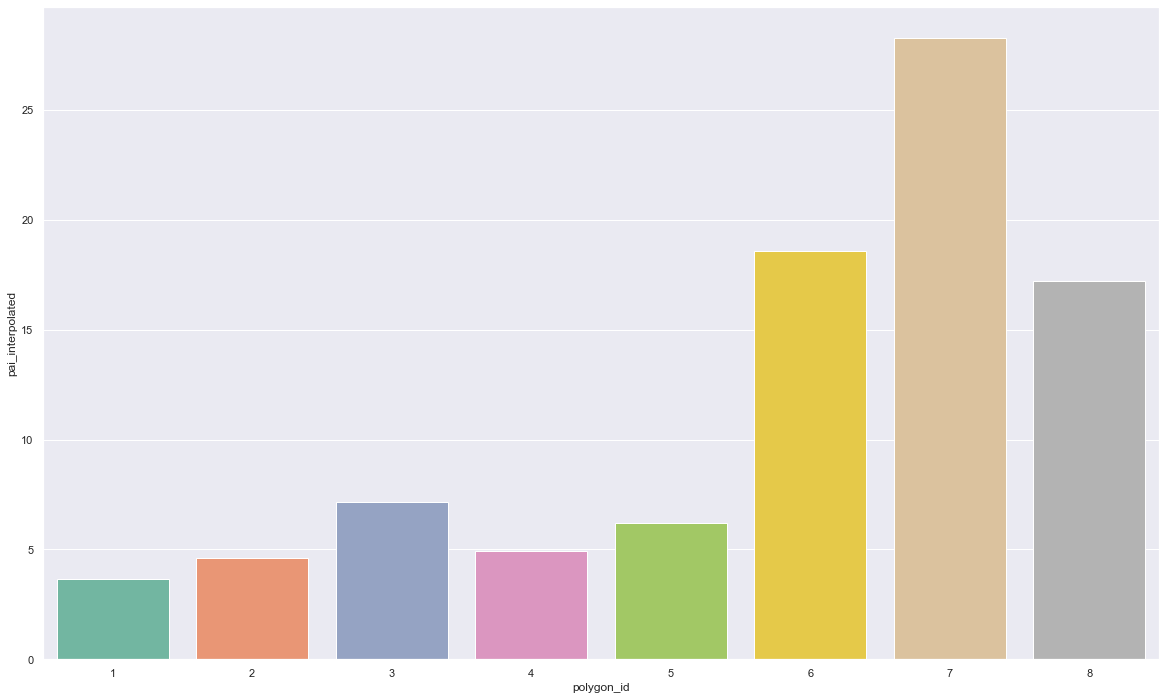

In [359]:
pai_cv = ((interpolated_gedi.groupby('polygon_id').std().pai_interpolated / interpolated_gedi.groupby('polygon_id').mean().pai_interpolated) * 100).reset_index()
ax = sns.barplot(pai_cv, x='polygon_id', y='pai_interpolated', palette=sns.color_palette("Set2"))
#ax.axes.set_title('Coefficient of Variation of Plant Area Index', fontsize=30)

In [207]:
precip_df.groupby(['polygon_id', 'month', 'year']).mean()

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/2519933458.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  precip_df.groupby(['polygon_id', 'month', 'year']).mean()


time  longitude   latitude  precipitation  \
polygon_id month year                                                      
1          1     2001  9.783072e+11 -73.661853  -1.347473     267.177488   
                 2002  1.009843e+12 -73.661853  -1.347473     148.131578   
                 2003  1.041379e+12 -73.661853  -1.347473     189.389654   
                 2004  1.072915e+12 -73.661853  -1.347473     116.427504   
                 2005  1.104538e+12 -73.661853  -1.347473     158.669387   
...                             ...        ...        ...            ...   
8          12    2018  1.543622e+12 -41.322503 -16.618833     208.116053   
                 2019  1.575158e+12 -41.322503 -16.618833     104.845874   
                 2020  1.606781e+12 -41.307531 -16.573917      38.026561   
                 2021  1.638317e+12 -41.386668 -16.586750     416.871599   
                 2022  1.669853e+12 -41.210214 -16.543973     394.875102   

                              PET       P-PET  
polygon_id month year                          
1          1     2001  178.177033   89.000454  
                 2002  213.932292  -65.800714  
                 2003  181.624479    7.765175  
                 2004  185.334019  -68.906515  
                 2005  177.009650  -18.340263  
...                           ...         ...  
8          12    2018  255.584658  -47.468605  
                 2019  255.722109 -150.876235  
                 2020  274.832748 -236.806188  
                 2021  224.518288  192.353311  
                 2022  189.986173  204.888929  

[2112 rows x 6 columns]

In [211]:
## Join PAI and climate data
#interpolated_gedi.set_index(['polygon_id', 'month', 'year'])
joined = precip_df.groupby(['polygon_id', 'month', 'year']).mean().join(interpolated_gedi.set_index(['polygon_id', 'month', 'year'])).dropna().drop(columns=['latitude', 'longitude', 'number', 'time']).reset_index()

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/3255839075.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  joined = precip_df.groupby(['polygon_id', 'month', 'year']).mean().join(interpolated_gedi.set_index(['polygon_id', 'month', 'year'])).dropna().drop(columns=['latitude', 'longitude', 'number', 'time']).reset_index()


<AxesSubplot: xlabel='precipitation', ylabel='pai_interpolated'>

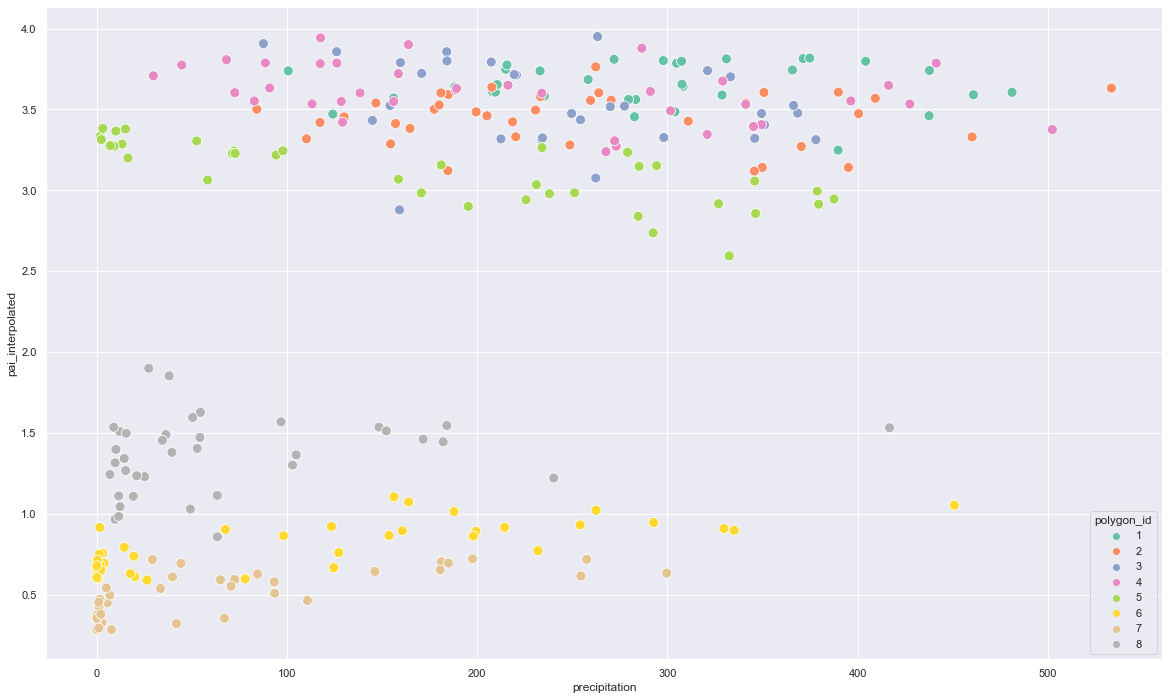

In [215]:
sns.scatterplot(joined, x='precipitation', y='pai_interpolated', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))

<AxesSubplot: xlabel='radiation', ylabel='pai'>

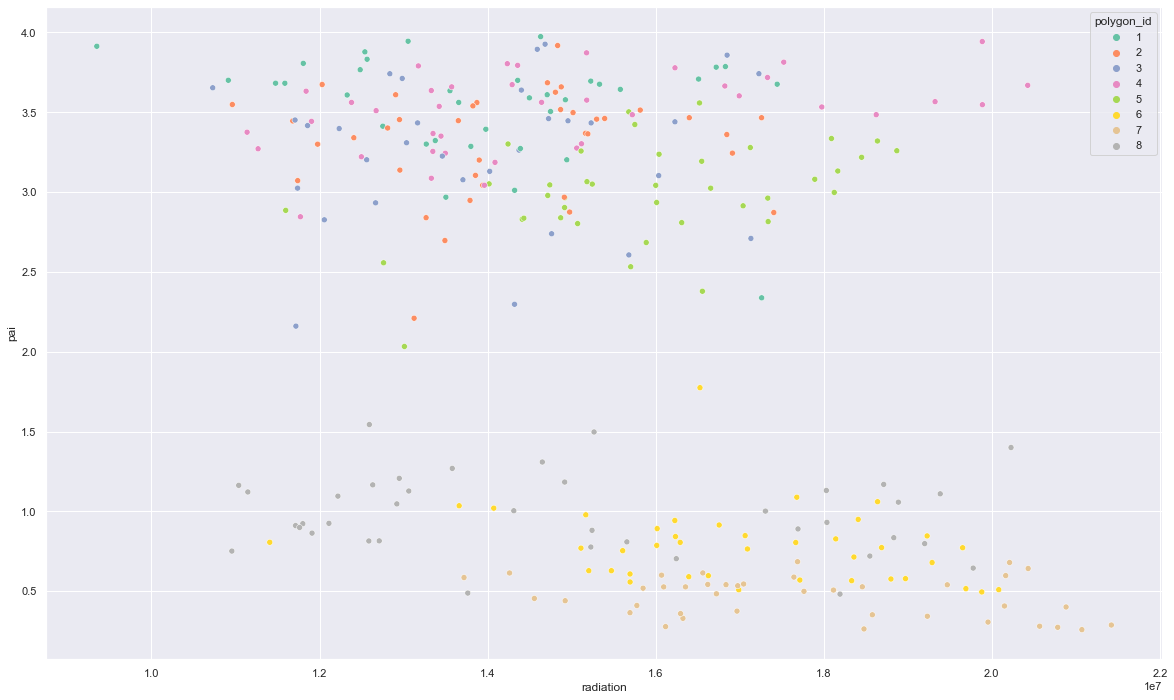

In [149]:
sns.scatterplot(monthly_data, x='radiation', y='pai', hue='polygon_id', palette=sns.color_palette("Set2"))

In [163]:
monthly_data = dfext.add_date_column(monthly_data).sort_values('date')

In [232]:
joined = dfext.add_datetime_column(joined.drop(columns='date'))

In [233]:
def shift_data(df, column, amount):
    # Polygon 1.
    all_polygons = []
    for polygon_id in range(1, 9):
        polygon_climate = df[(df.polygon_id==polygon_id)].sort_values('datetime')
        for i in range(0, amount + 1):
            if i==0:
                continue
            polygon_climate[f"{column}_{i}"] = polygon_climate[column].shift(i)
        all_polygons.append(polygon_climate)
    return pd.concat(all_polygons)

In [313]:
shifted_2 = shift_data(joined, 'precipitation', 2)
shifted_2 = shift_data(shifted_2, 'pai_interpolated', 1)
shifted_2['delta_pai'] = shifted_2.pai_interpolated - shifted_2.pai_interpolated_1
#shifted_2 = shifted_2.dropna()
shifted_2[shifted_2.polygon_id == 1].sort_values('datetime')

,polygon_id,month,year,precipitation,PET,P-PET,pai,rh100,pai_interpolated,datetime,precipitation_1,precipitation_2,pai_interpolated_1,delta_pai
11,1,5,2019,404.282179,126.156778,278.125401,3.766817,2731.935935,3.798004,2019-05-01,NaN,NaN,NaN,NaN
15,1,6,2019,365.773350,113.124350,252.649000,3.913649,2847.959920,3.743782,2019-06-01,404.282179,NaN,3.798004,-0.054222
18,1,7,2019,304.892656,144.883269,160.009387,3.608399,2711.856065,3.785950,2019-07-01,365.773350,404.282179,3.743782,0.042168
20,1,8,2019,214.995886,189.265877,25.730009,3.973964,2822.755271,3.748627,2019-08-01,304.892656,365.773350,3.785950,-0.037323
23,1,9,2019,233.057892,177.740439,55.317453,3.786409,2815.184880,3.738078,2019-09-01,214.995886,304.892656,3.748627,-0.010549
26,1,10,2019,258.358570,152.984652,105.373918,3.505084,2403.389899,3.684638,2019-10-01,233.057892,214.995886,3.738078,-0.053440
28,1,11,2019,307.709148,113.412265,194.296883,3.700267,2558.171728,3.655693,2019-11-01,258.358570,233.057892,3.684638,-0.028945
31,1,12,2019,437.867238,128.729421,309.137817,3.945133,2864.942473,3.740804,2019-12-01,307.709148,258.358570,3.655693,0.085110
0,1,1,2020,100.667677,167.430116,-66.762439,3.676017,2698.007120,3.738257,2020-01-01,437.867238,307.709148,3.740804,-0.002547
3,1,2,2020,208.183972,171.936282,36.247690,3.286510,2234.657768,3.607430,2020-02-01,100.667677,437.867238,3.738257,-0.130826


In [314]:
shifted_2 = shift_data(shifted_2, 'P-PET', 2)
shifted_2

,polygon_id,month,year,precipitation,PET,P-PET,pai,rh100,pai_interpolated,datetime,precipitation_1,precipitation_2,pai_interpolated_1,delta_pai,P-PET_1,P-PET_2
11,1,5,2019,404.282179,126.156778,278.125401,3.766817,2731.935935,3.798004,2019-05-01,NaN,NaN,NaN,NaN,NaN,NaN
15,1,6,2019,365.773350,113.124350,252.649000,3.913649,2847.959920,3.743782,2019-06-01,404.282179,NaN,3.798004,-0.054222,278.125401,NaN
18,1,7,2019,304.892656,144.883269,160.009387,3.608399,2711.856065,3.785950,2019-07-01,365.773350,404.282179,3.743782,0.042168,252.649000,278.125401
20,1,8,2019,214.995886,189.265877,25.730009,3.973964,2822.755271,3.748627,2019-08-01,304.892656,365.773350,3.785950,-0.037323,160.009387,252.649000
23,1,9,2019,233.057892,177.740439,55.317453,3.786409,2815.184880,3.738078,2019-09-01,214.995886,304.892656,3.748627,-0.010549,25.730009,160.009387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,8,1,2022,96.829598,261.600414,-164.770816,1.597032,1386.197647,1.567903,2022-01-01,416.871599,240.223877,1.531489,0.036414,192.353311,9.481020
254,8,2,2022,148.404782,210.683255,-62.278473,1.515809,1297.919529,1.535354,2022-02-01,96.829598,416.871599,1.567903,-0.032549,-164.770816,192.353311
257,8,3,2022,36.354512,234.606257,-198.251745,1.382222,1234.216282,1.489077,2022-03-01,148.404782,96.829598,1.535354,-0.046277,-62.278473,-164.770816
260,8,4,2022,34.483665,199.970383,-165.486718,1.531108,1323.186849,1.453952,2022-04-01,36.354512,148.404782,1.489077,-0.035125,-198.251745,-62.278473


In [176]:
shifted = shift_data(shifted, 'pai', 1)

In [178]:
shifted['delta_pai'] = shifted.pai - shifted.pai_1

<AxesSubplot: xlabel='precipitation_2', ylabel='delta_pai'>

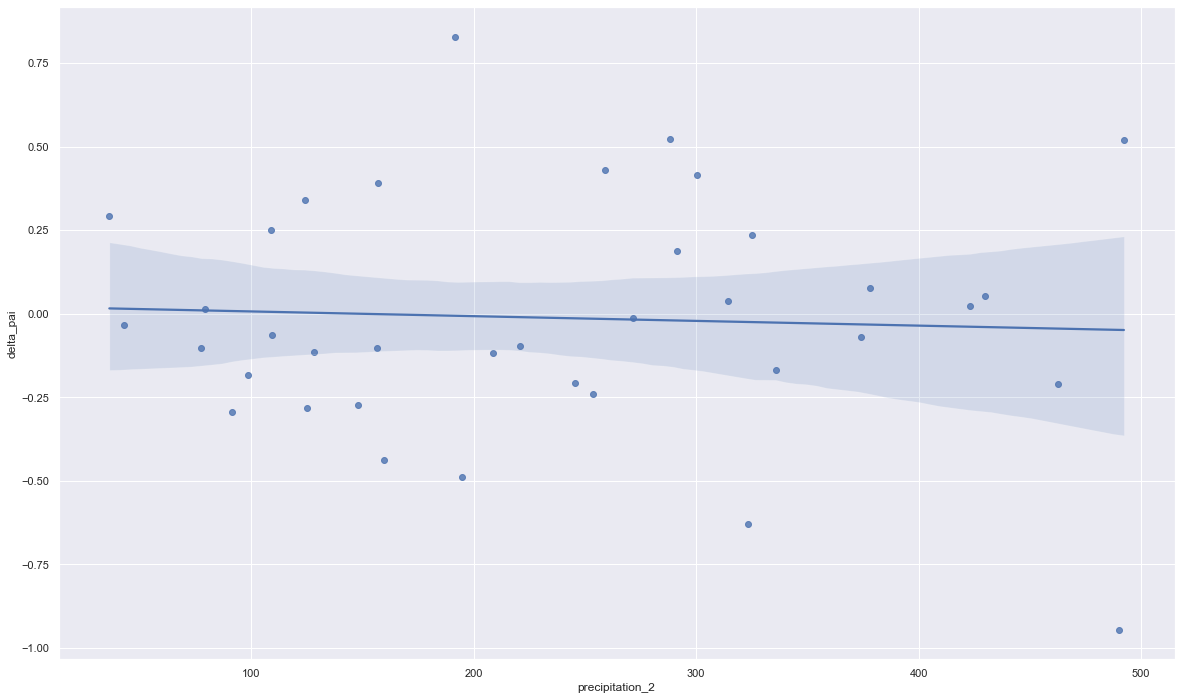

In [193]:
sns.regplot(shifted[shifted.polygon_id==4], x='precipitation_2', y='delta_pai',)

<AxesSubplot: xlabel='precipitation', ylabel='delta_pai'>

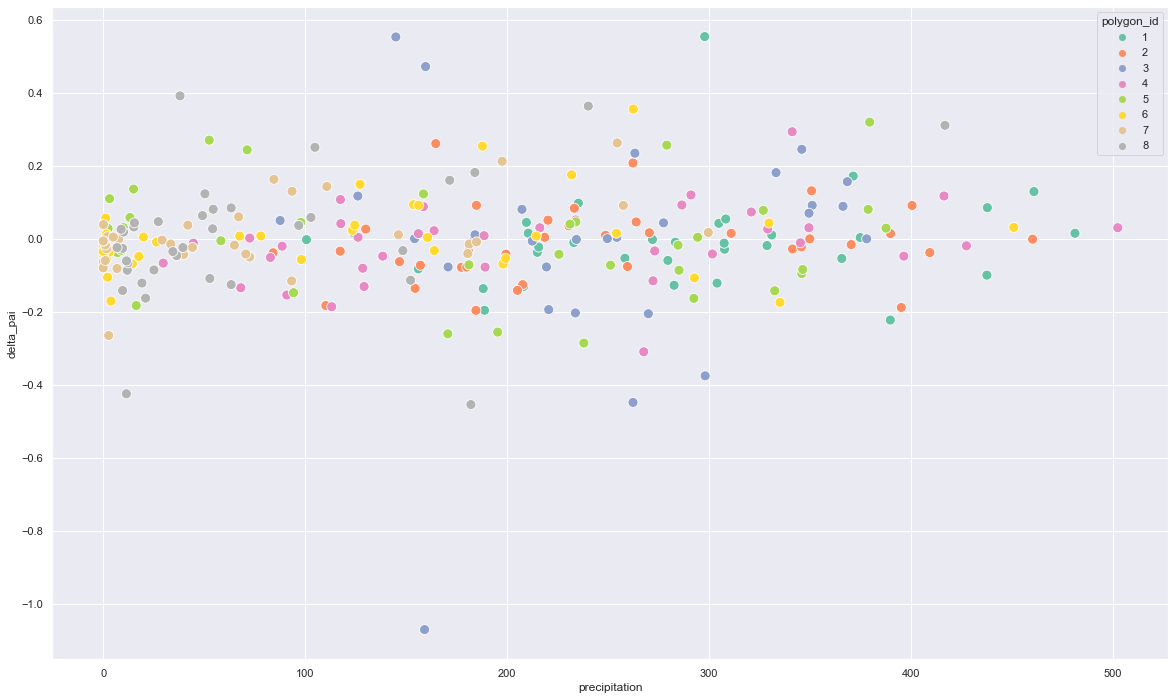

In [237]:
sns.scatterplot(shifted_2, x='precipitation', y='delta_pai', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/707499831.py:1: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.scatterplot(shifted_2[shifted_2.polygon_id > 5], x='precipitation', y='delta_pai', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))


<AxesSubplot: xlabel='precipitation', ylabel='delta_pai'>

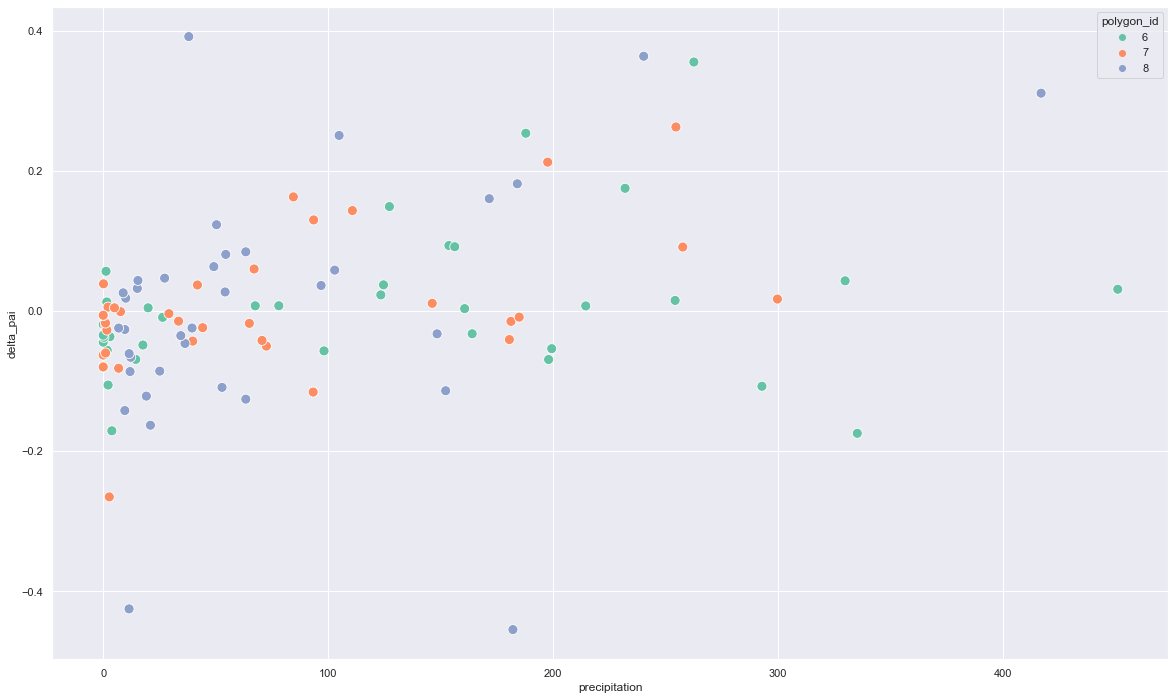

In [242]:
sns.scatterplot(shifted_2[shifted_2.polygon_id > 5], x='precipitation', y='delta_pai', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))

<AxesSubplot: xlabel='precipitation', ylabel='delta_pai'>

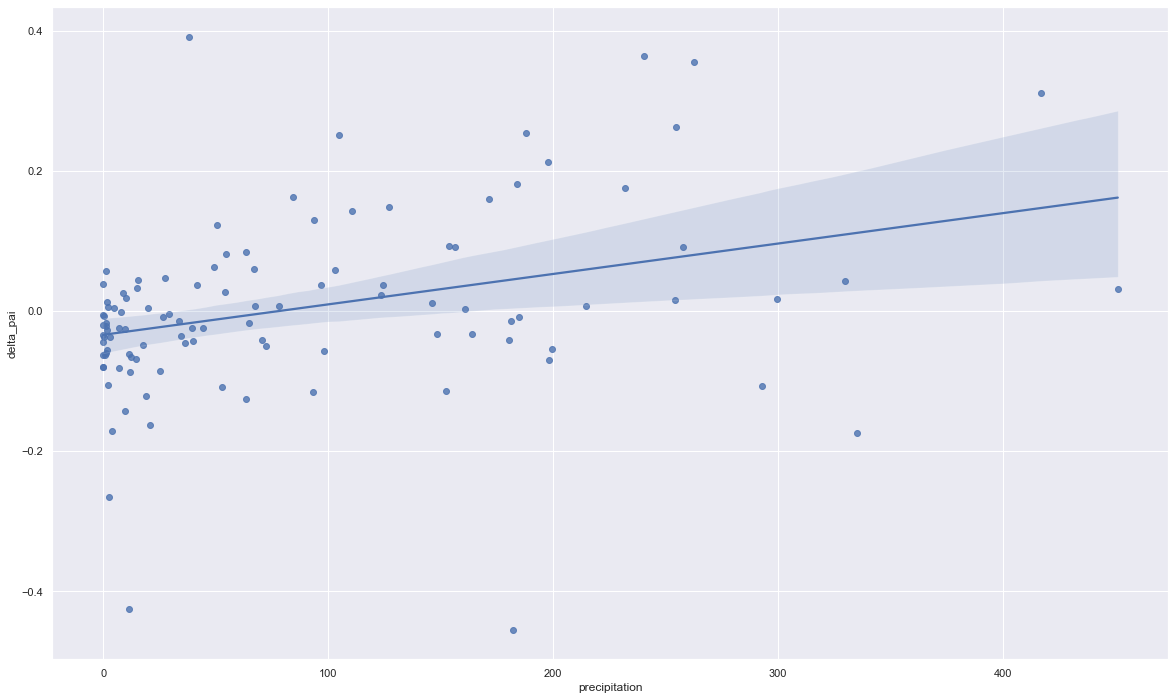

In [243]:
sns.regplot(shifted_2[shifted_2.polygon_id > 5], x='precipitation', y='delta_pai')

<AxesSubplot: xlabel='precipitation', ylabel='pai_interpolated'>

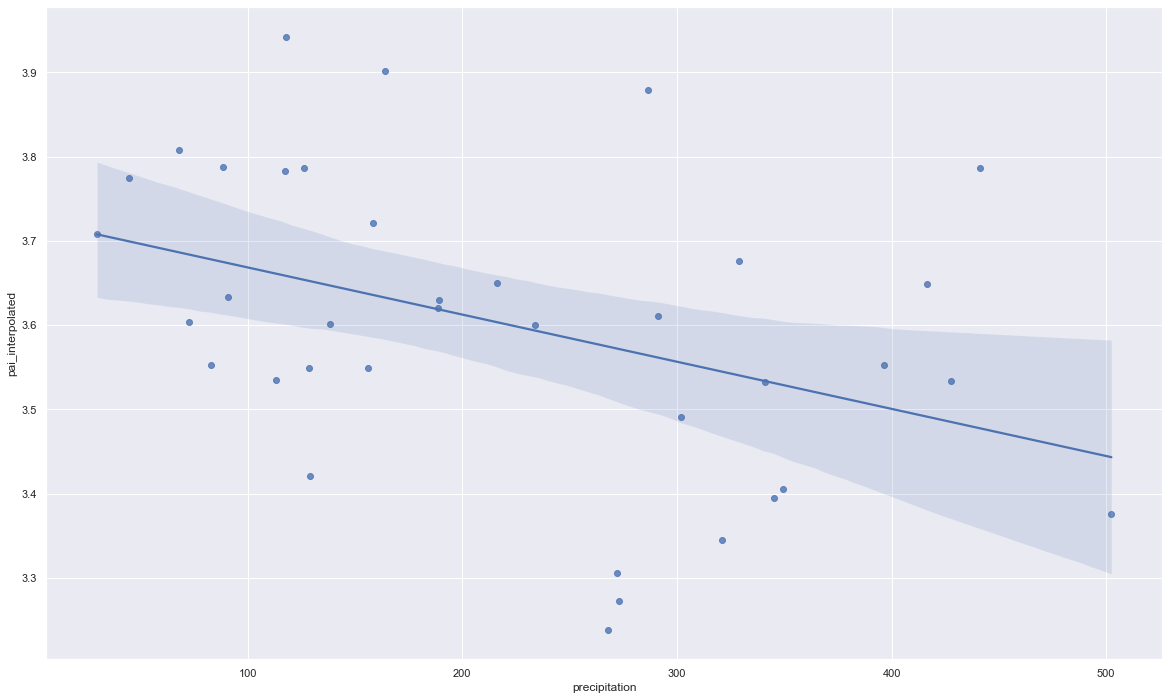

In [253]:
sns.regplot(shifted_2[shifted_2.polygon_id == 4], x='precipitation', y='pai_interpolated')

Text(0.5, 1.0, '[Polygons 1-6] Precipitation vs. PAI in months when the forests are not in water deficit')

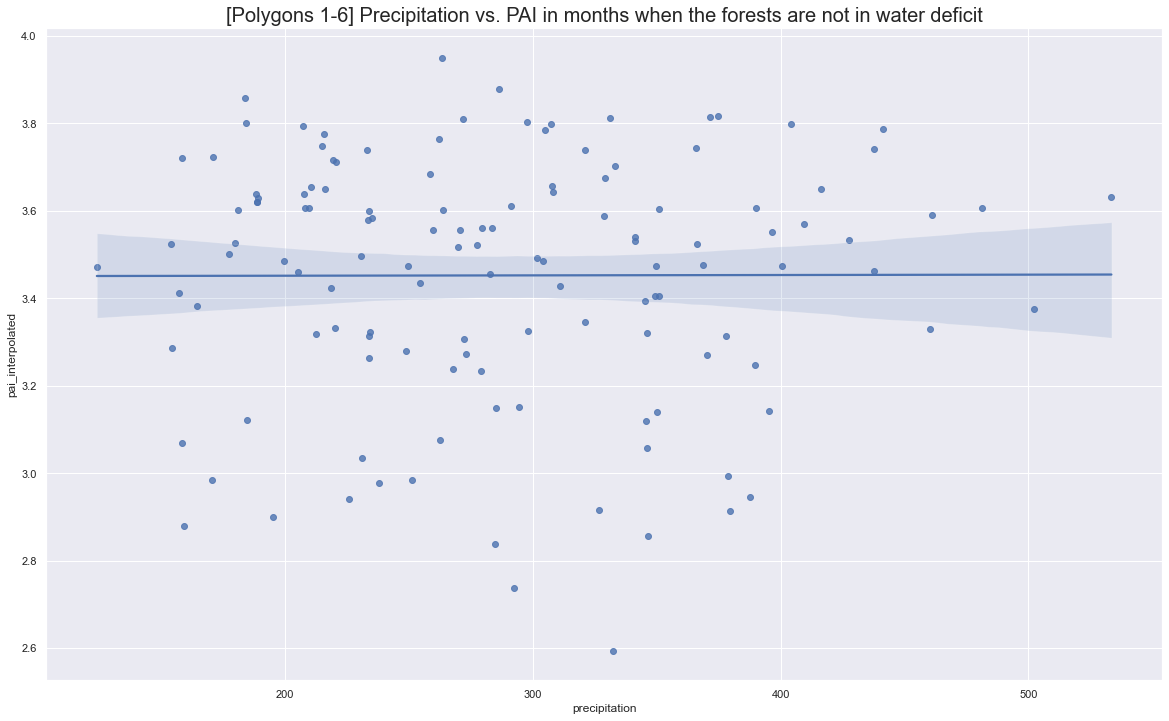

In [287]:
ax = sns.regplot(shifted_2[(shifted_2.polygon_id < 6) & (~shifted_2.water_deficit)], x='precipitation', y='pai_interpolated')
ax.set_title('[Polygons 1-6] Precipitation vs. PAI in months when the forests are not in water deficit', fontsize=20)

Text(0.5, 1.0, '[Polygons 1-6] Precipitation vs. PAI in months when the forests are in water deficit')

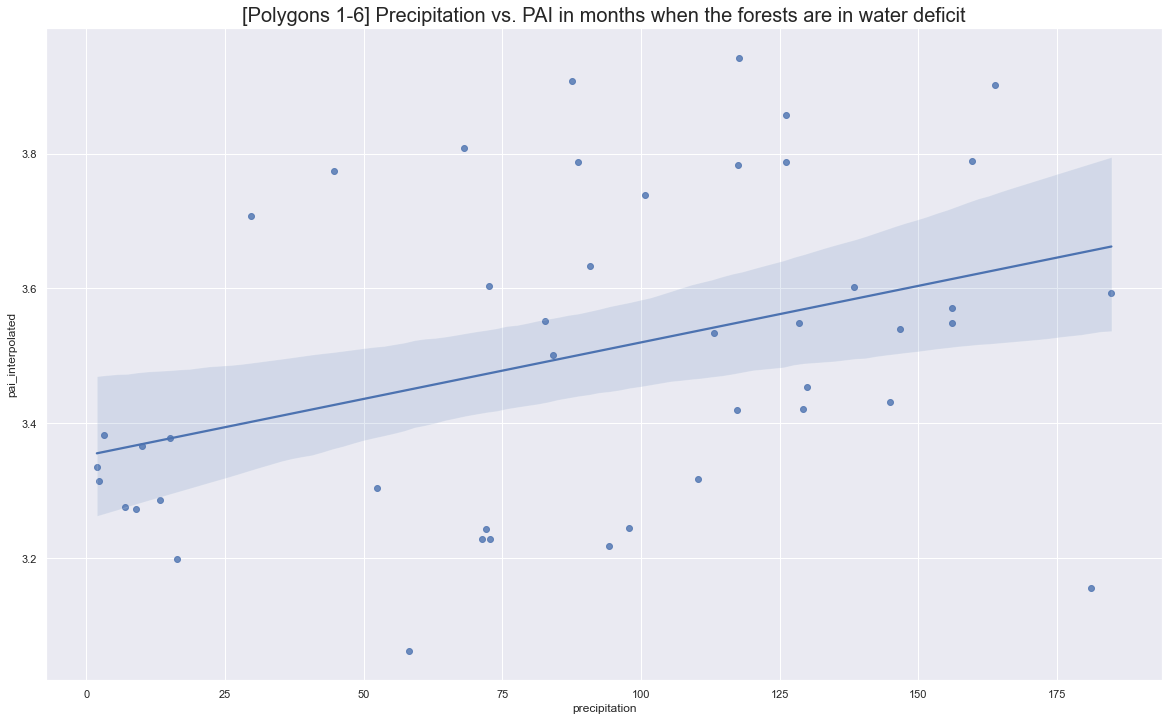

In [288]:
ax = sns.regplot(shifted_2[(shifted_2.polygon_id < 6) & (shifted_2.water_deficit)], x='precipitation', y='pai_interpolated')
ax.set_title('[Polygons 1-6] Precipitation vs. PAI in months when the forests are in water deficit', fontsize=20)

In [281]:
from scipy import stats
amazon_in_water_deficit = shifted_2[(shifted_2.polygon_id > 6) & (shifted_2.water_deficit)]
slope, intercept, r_value, p_value, std_err = stats.linregress(amazon_in_water_deficit.precipitation, y=amazon_in_water_deficit.pai_interpolated)
print(p_value)

0.11652388261552168


In [261]:
shifted_2['water_deficit'] = shifted_2['P-PET'] < 0

In [262]:
shifted_2

,polygon_id,month,year,precipitation,PET,P-PET,pai,rh100,pai_interpolated,datetime,precipitation_1,precipitation_2,pai_interpolated_1,delta_pai,water_deficit
11,1,5,2019,404.282179,126.156778,278.125401,3.766817,2731.935935,3.798004,2019-05-01,NaN,NaN,NaN,NaN,False
15,1,6,2019,365.773350,113.124350,252.649000,3.913649,2847.959920,3.743782,2019-06-01,404.282179,NaN,3.798004,-0.054222,False
18,1,7,2019,304.892656,144.883269,160.009387,3.608399,2711.856065,3.785950,2019-07-01,365.773350,404.282179,3.743782,0.042168,False
20,1,8,2019,214.995886,189.265877,25.730009,3.973964,2822.755271,3.748627,2019-08-01,304.892656,365.773350,3.785950,-0.037323,False
23,1,9,2019,233.057892,177.740439,55.317453,3.786409,2815.184880,3.738078,2019-09-01,214.995886,304.892656,3.748627,-0.010549,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,8,1,2022,96.829598,261.600414,-164.770816,1.597032,1386.197647,1.567903,2022-01-01,416.871599,240.223877,1.531489,0.036414,True
254,8,2,2022,148.404782,210.683255,-62.278473,1.515809,1297.919529,1.535354,2022-02-01,96.829598,416.871599,1.567903,-0.032549,True
257,8,3,2022,36.354512,234.606257,-198.251745,1.382222,1234.216282,1.489077,2022-03-01,148.404782,96.829598,1.535354,-0.046277,True
260,8,4,2022,34.483665,199.970383,-165.486718,1.531108,1323.186849,1.453952,2022-04-01,36.354512,148.404782,1.489077,-0.035125,True


/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/2729799488.py:1: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.scatterplot(shifted_2[(shifted_2.polygon_id < 6) & (shifted_2.water_deficit)], x='precipitation', y='pai_interpolated', hue='water_deficit', s=100, palette=sns.color_palette("Set2"))


<AxesSubplot: xlabel='precipitation', ylabel='pai_interpolated'>

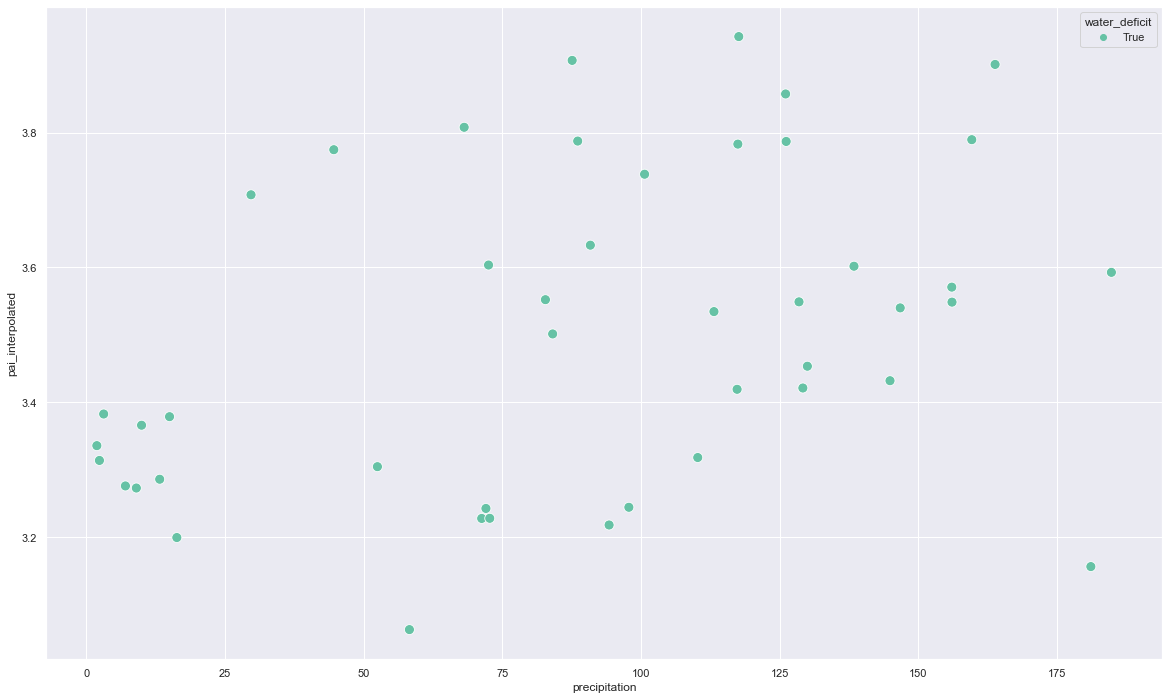

In [265]:
sns.scatterplot(shifted_2[(shifted_2.polygon_id < 6) & (shifted_2.water_deficit)], x='precipitation', y='pai_interpolated', hue='water_deficit', s=100, palette=sns.color_palette("Set2"))

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/2166534624.py:1: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.scatterplot(shifted_2[shifted_2.polygon_id > 5], x='P-PET', y='pai_interpolated', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))


<AxesSubplot: xlabel='P-PET', ylabel='pai_interpolated'>

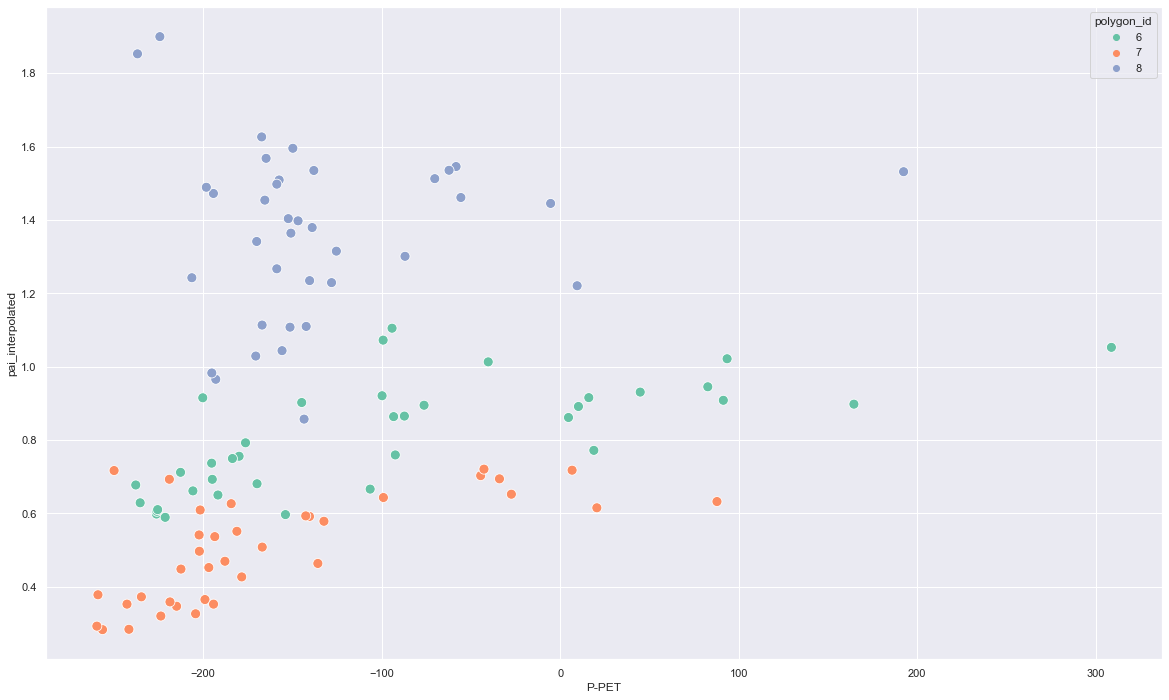

In [292]:
sns.scatterplot(shifted_2[shifted_2.polygon_id > 5], x='P-PET', y='pai_interpolated', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))

Text(0.5, 1.0, '[Polygons 6-8] Water Availability vs. PAI')

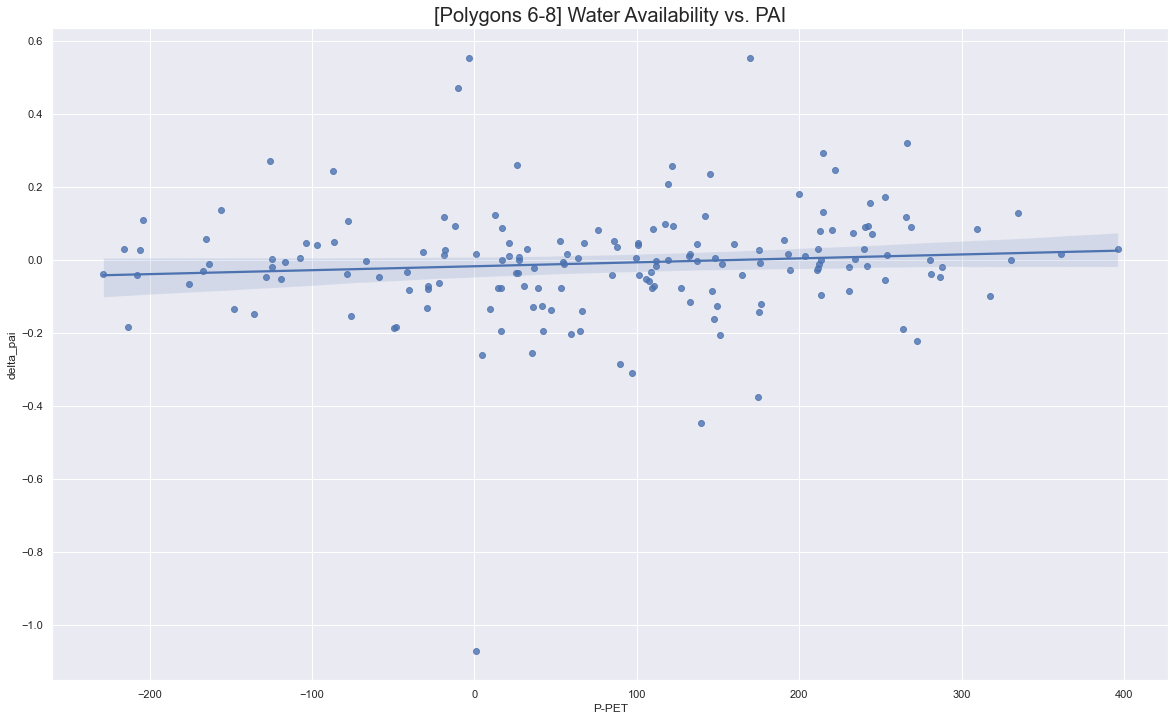

In [297]:
ax = sns.regplot(shifted_2[shifted_2.polygon_id < 6], x='P-PET', y='delta_pai')
ax.set_title('[Polygons 6-8] Water Availability vs. PAI', fontsize=20)

In [304]:
from scipy import stats
amazon_in_water_deficit = shifted_2[(shifted_2.polygon_id < 6)].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(x=amazon_in_water_deficit['P-PET'], y=amazon_in_water_deficit.pai_interpolated)
print(p_value)

0.27858852902043396


In [310]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

amazon_in_water_deficit = shifted_2[(shifted_2.polygon_id < 6) & (shifted_2.water_deficit)].dropna()
model = sm.OLS(amazon_in_water_deficit['delta_pai'], sm.add_constant(amazon_in_water_deficit['precipitation_2'])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_pai   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     8.526
Date:                Fri, 03 Mar 2023   Prob (F-statistic):            0.00573
Time:                        08:18:04   Log-Likelihood:                 24.528
No. Observations:                  42   AIC:                            -45.06
Df Residuals:                      40   BIC:                            -41.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0792      0.037     

                            OLS Regression Results                            
Dep. Variable:              delta_pai   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     8.526
Date:                Fri, 03 Mar 2023   Prob (F-statistic):            0.00573
Time:                        08:30:48   Log-Likelihood:                 24.528
No. Observations:                  42   AIC:                            -45.06
Df Residuals:                      40   BIC:                            -41.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0792      0.037     

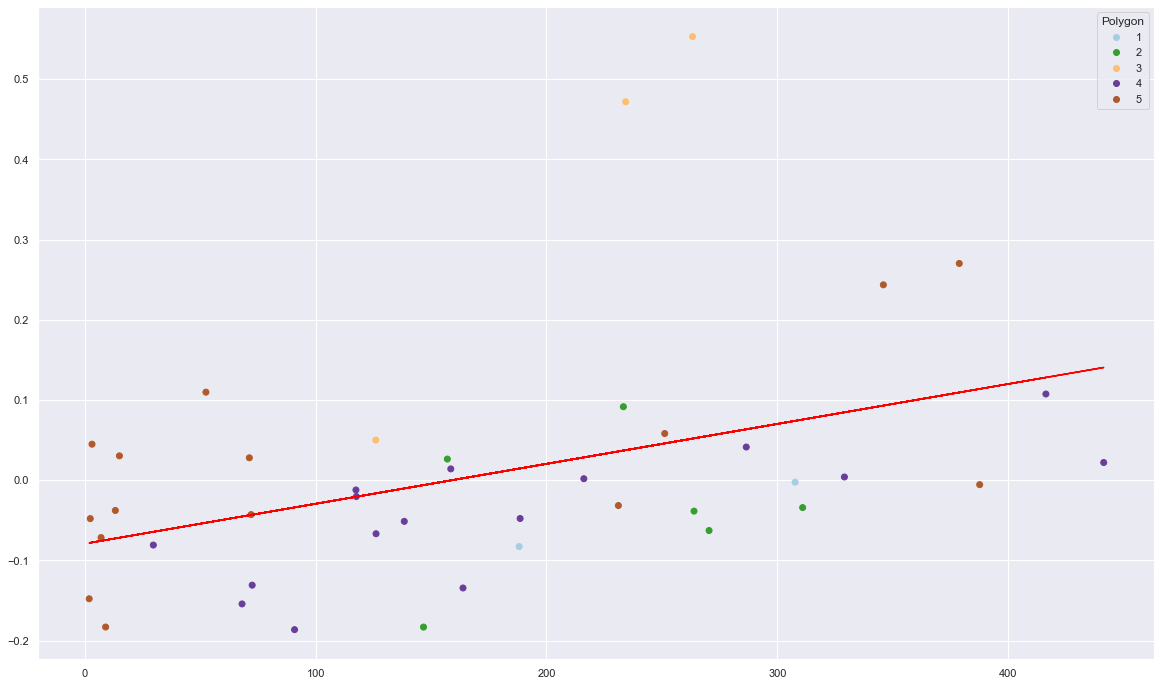

In [326]:
def plot_lin_reg(df, x, y, hue):
    model = sm.OLS(df[y], sm.add_constant(df[x])).fit()
    sc = plt.scatter(df[x], df[y], c = pd.Categorical(df[hue]).codes, cmap=plt.cm.Paired)
    plt.plot(df[x], model.predict(), color='red')
    #plt.xlabel('Palmer Drought Severity Index')
    #plt.ylabel('Plant Area Index')
    categories = [i for i in range(df[hue].min(),df[hue].max() + 1)]
    handles, labels = sc.legend_elements()
    plt.legend(handles, categories, title='Polygon')
    print(model.summary())
    plt.show()

plot_lin_reg(amazon_in_water_deficit, 'precipitation_2', 'delta_pai', 'polygon_id')

In [322]:
shifted_2['water_deficit'] = shifted_2['P-PET'] < 0
amazon_polygons = shifted_2[shifted_2.polygon_id < 6]
cerrado = shifted_2[shifted_2.polygon_id > 5]

                            OLS Regression Results                            
Dep. Variable:              delta_pai   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     5.038
Date:                Fri, 03 Mar 2023   Prob (F-statistic):             0.0261
Time:                        08:26:52   Log-Likelihood:                 68.533
No. Observations:                 165   AIC:                            -133.1
Df Residuals:                     163   BIC:                            -126.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0267      0.014     -1.851      0.0

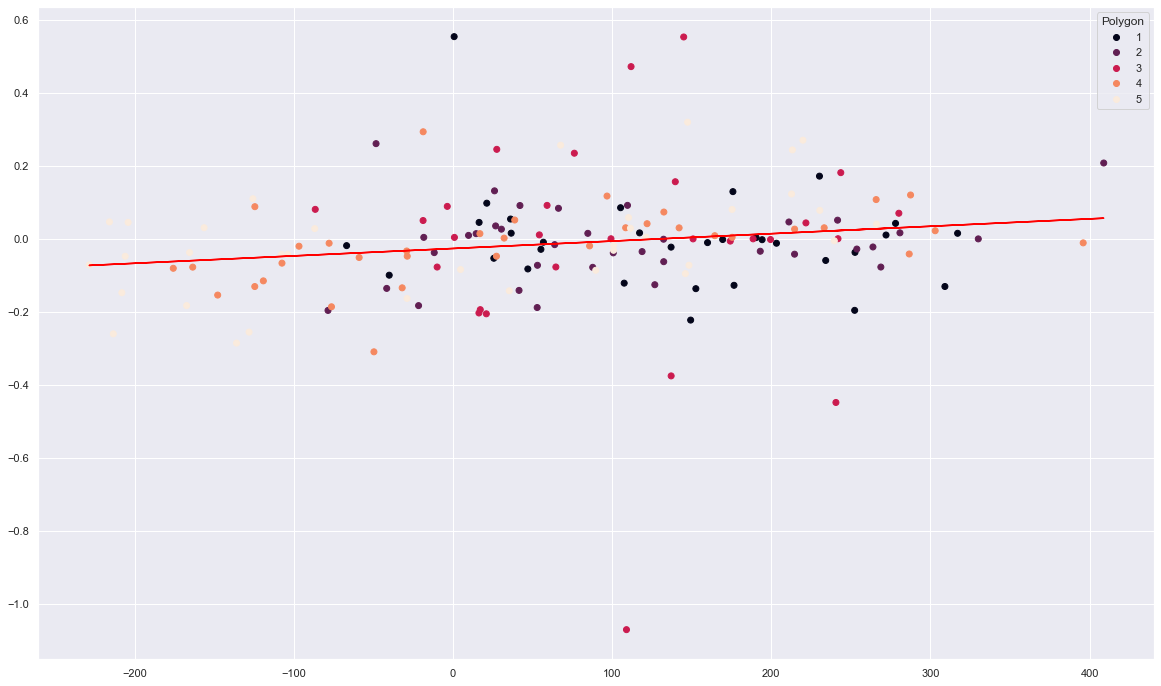

In [321]:
plot_lin_reg(amazon_polygons.dropna(), 'P-PET_2', 'delta_pai', 'polygon_id')

                            OLS Regression Results                            
Dep. Variable:              delta_pai   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     10.73
Date:                Fri, 03 Mar 2023   Prob (F-statistic):            0.00218
Time:                        08:32:00   Log-Likelihood:                 25.461
No. Observations:                  42   AIC:                            -46.92
Df Residuals:                      40   BIC:                            -43.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.021      0.196      0.8

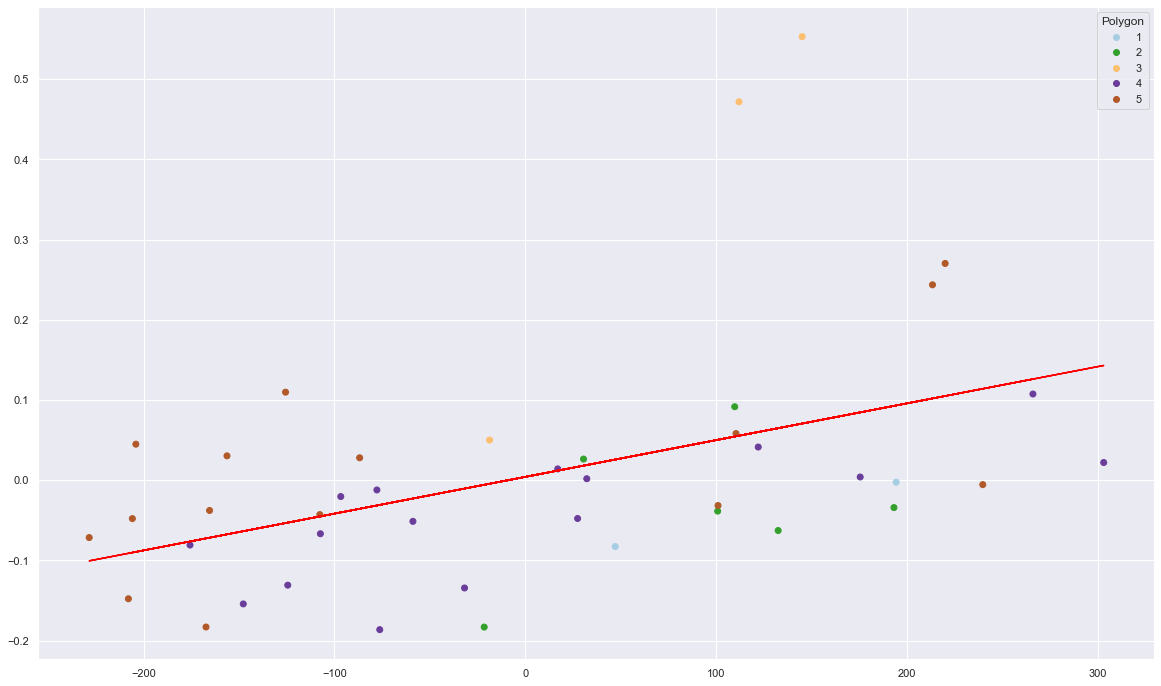

In [327]:
plot_lin_reg(amazon_polygons[amazon_polygons.water_deficit].dropna(), 'P-PET_2', 'delta_pai', 'polygon_id')

                            OLS Regression Results                            
Dep. Variable:              delta_pai   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     8.526
Date:                Fri, 03 Mar 2023   Prob (F-statistic):            0.00573
Time:                        08:42:03   Log-Likelihood:                 24.528
No. Observations:                  42   AIC:                            -45.06
Df Residuals:                      40   BIC:                            -41.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0792      0.037     

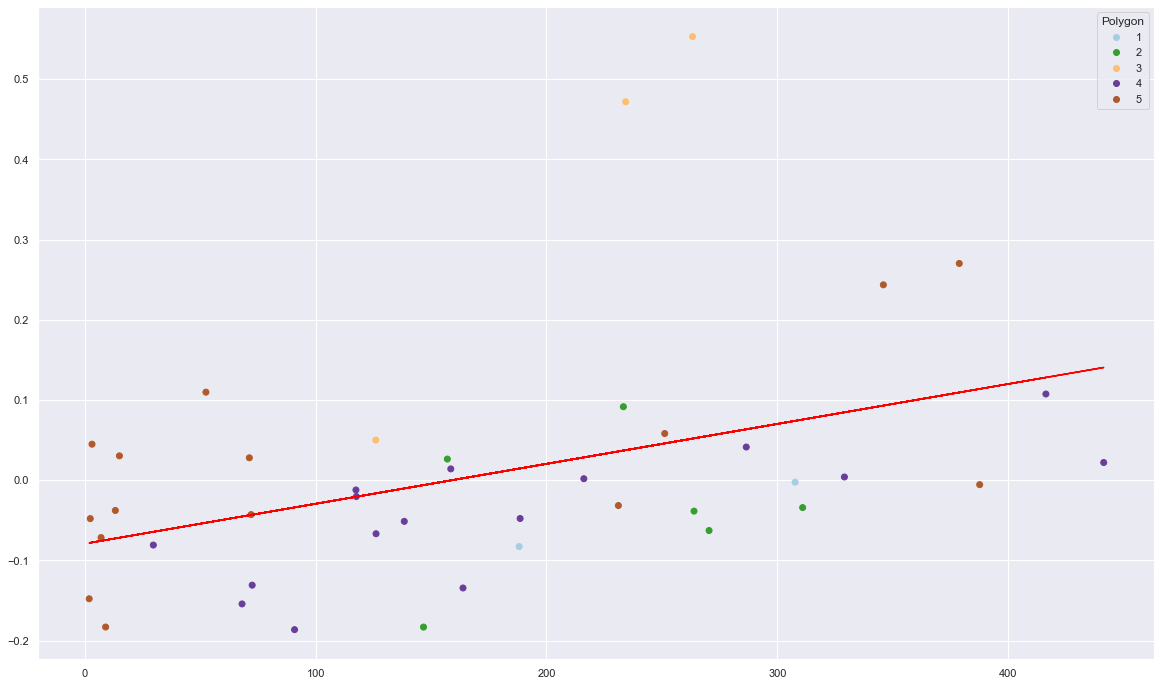

In [338]:
plot_lin_reg(amazon_polygons[amazon_polygons.water_deficit].dropna(), 'precipitation_2', 'delta_pai', 'polygon_id')

In [330]:
amazon_polygons['water_deficit_1'] = amazon_polygons['P-PET_1'] < 0
amazon_polygons['water_deficit_2'] = amazon_polygons['P-PET_2'] < 0

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/3451884588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_polygons['water_deficit_1'] = amazon_polygons['P-PET_1'] < 0
/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/3451884588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_polygons['water_deficit_2'] = amazon_polygons['P-PET_2'] < 0


                            OLS Regression Results                            
Dep. Variable:       pai_interpolated   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5.917
Date:                Fri, 03 Mar 2023   Prob (F-statistic):             0.0196
Time:                        08:42:45   Log-Likelihood:                 5.1732
No. Observations:                  42   AIC:                            -6.346
Df Residuals:                      40   BIC:                            -2.871
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.3620      0.067     50.428

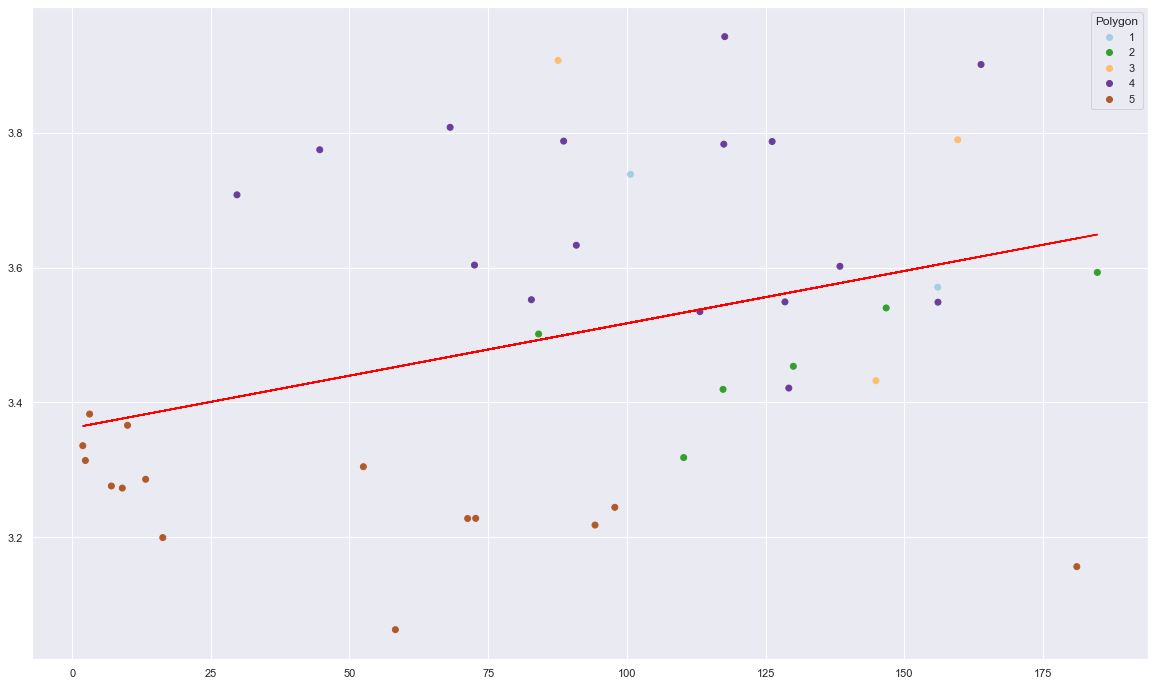

In [339]:
plot_lin_reg(amazon_polygons[amazon_polygons.water_deficit].dropna(), 'precipitation', 'pai_interpolated', 'polygon_id')

                            OLS Regression Results                            
Dep. Variable:              delta_pai   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.568
Date:                Fri, 03 Mar 2023   Prob (F-statistic):              0.121
Time:                        10:23:33   Log-Likelihood:                 19.329
No. Observations:                  28   AIC:                            -34.66
Df Residuals:                      26   BIC:                            -31.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1213      0.052     

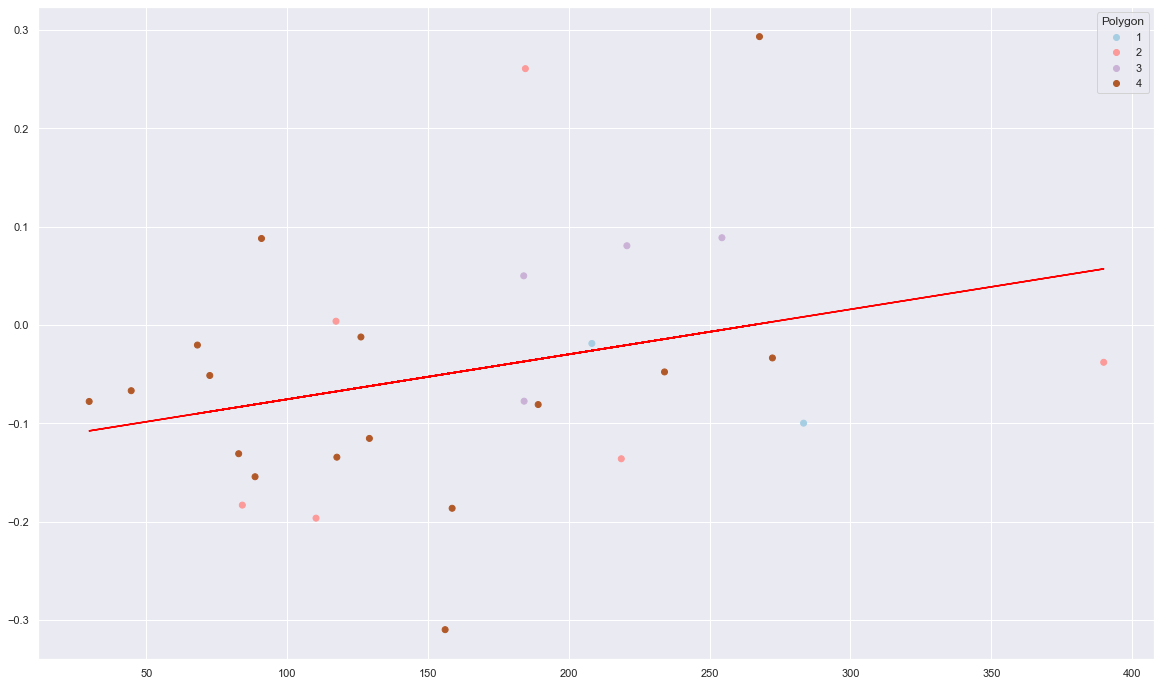

In [345]:
plot_lin_reg(amazon_polygons[amazon_polygons.water_deficit_2 & (amazon_polygons.polygon_id<5)].dropna(), 'precipitation_1', 'delta_pai', 'polygon_id')

                            OLS Regression Results                            
Dep. Variable:              delta_pai   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.6759
Date:                Fri, 03 Mar 2023   Prob (F-statistic):              0.416
Time:                        10:45:37   Log-Likelihood:                 20.822
No. Observations:                  42   AIC:                            -37.64
Df Residuals:                      40   BIC:                            -34.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0252      0.046     -0.548

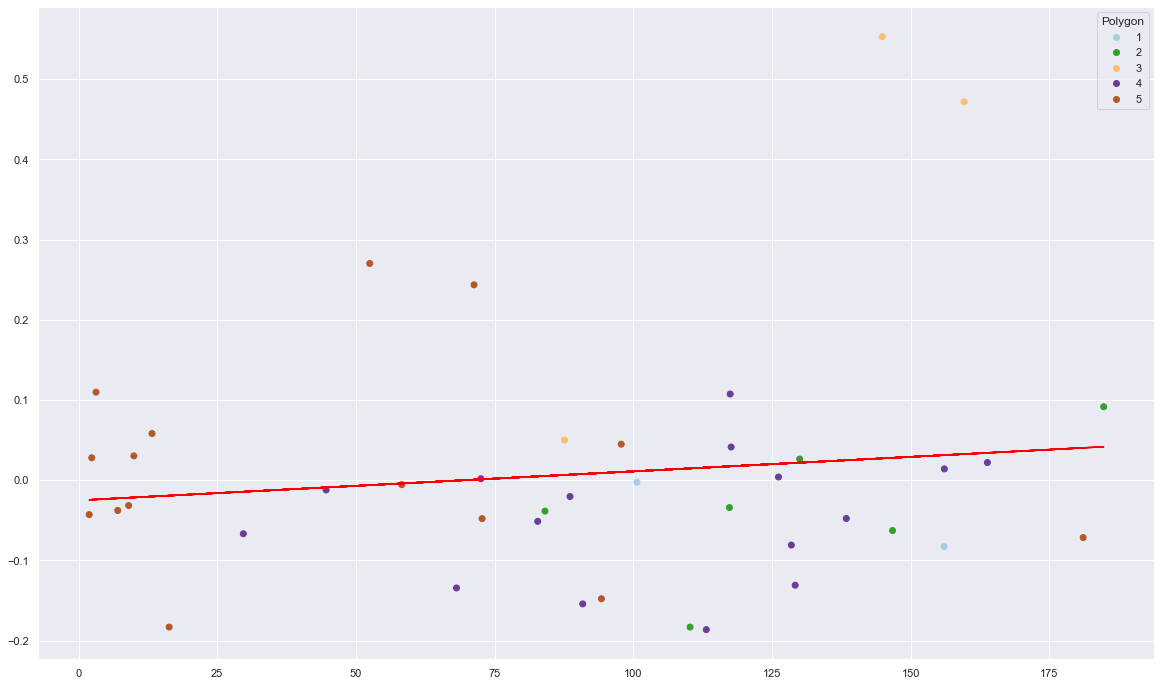

In [352]:
plot_lin_reg(amazon_polygons[(amazon_polygons.water_deficit)].dropna(), 'precipitation', 'delta_pai', 'polygon_id')

                            OLS Regression Results                            
Dep. Variable:              delta_pai   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     13.17
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           0.000444
Time:                        10:43:57   Log-Likelihood:                 72.039
No. Observations:                 105   AIC:                            -140.1
Df Residuals:                     103   BIC:                            -134.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0338      0.016     -2.102

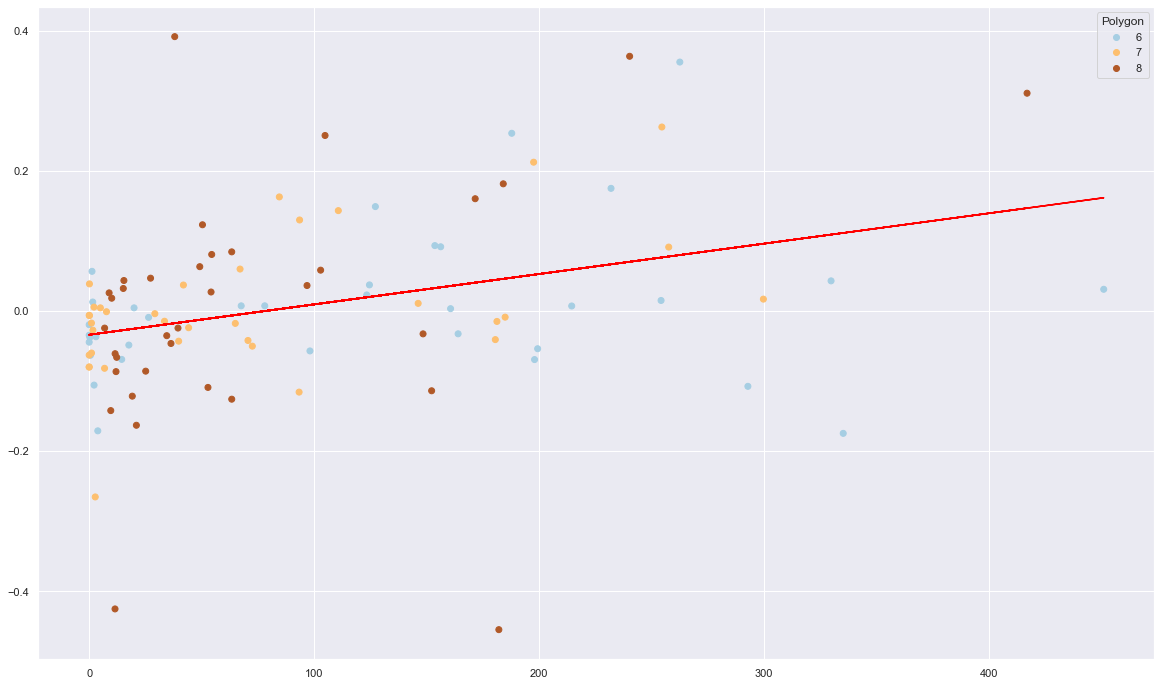

In [351]:
plot_lin_reg(cerrado.dropna(), 'precipitation', 'delta_pai', 'polygon_id')

                            OLS Regression Results                            
Dep. Variable:       pai_interpolated   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5.917
Date:                Fri, 03 Mar 2023   Prob (F-statistic):             0.0196
Time:                        10:46:06   Log-Likelihood:                 5.1732
No. Observations:                  42   AIC:                            -6.346
Df Residuals:                      40   BIC:                            -2.871
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.3620      0.067     50.428

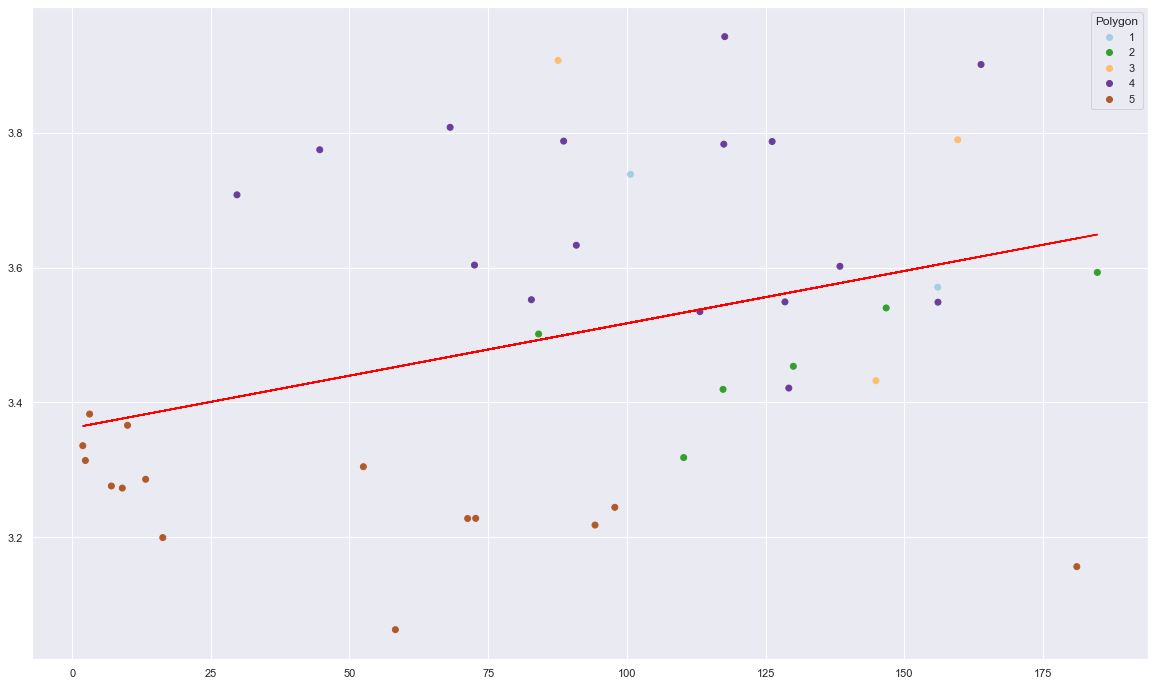

In [353]:
plot_lin_reg(amazon_polygons[(amazon_polygons.water_deficit)].dropna(), 'precipitation', 'pai_interpolated', 'polygon_id')

                            OLS Regression Results                            
Dep. Variable:       pai_interpolated   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9448
Date:                Fri, 03 Mar 2023   Prob (F-statistic):              0.332
Time:                        10:46:58   Log-Likelihood:                -15.758
No. Observations:                 165   AIC:                             35.52
Df Residuals:                     163   BIC:                             41.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.4948      0.048     73.093

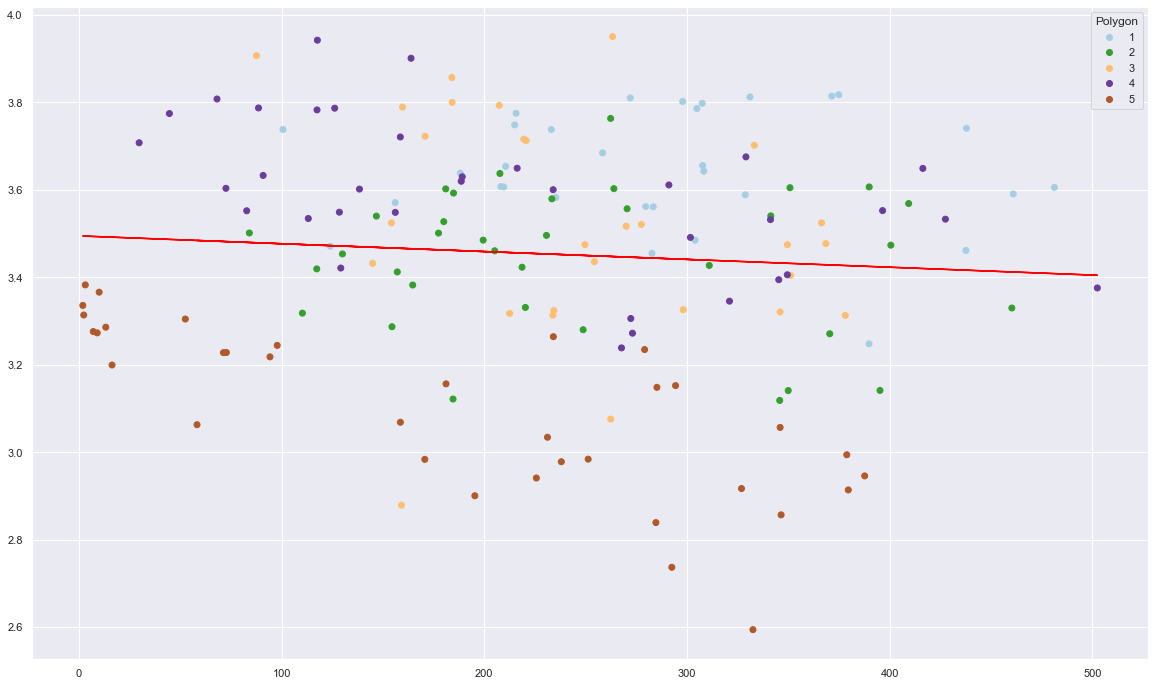

In [354]:
plot_lin_reg(amazon_polygons.dropna(), 'precipitation', 'pai_interpolated', 'polygon_id')

                            OLS Regression Results                            
Dep. Variable:       pai_interpolated   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5.917
Date:                Fri, 03 Mar 2023   Prob (F-statistic):             0.0196
Time:                        11:27:16   Log-Likelihood:                 5.1732
No. Observations:                  42   AIC:                            -6.346
Df Residuals:                      40   BIC:                            -2.871
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.3620      0.067     50.428

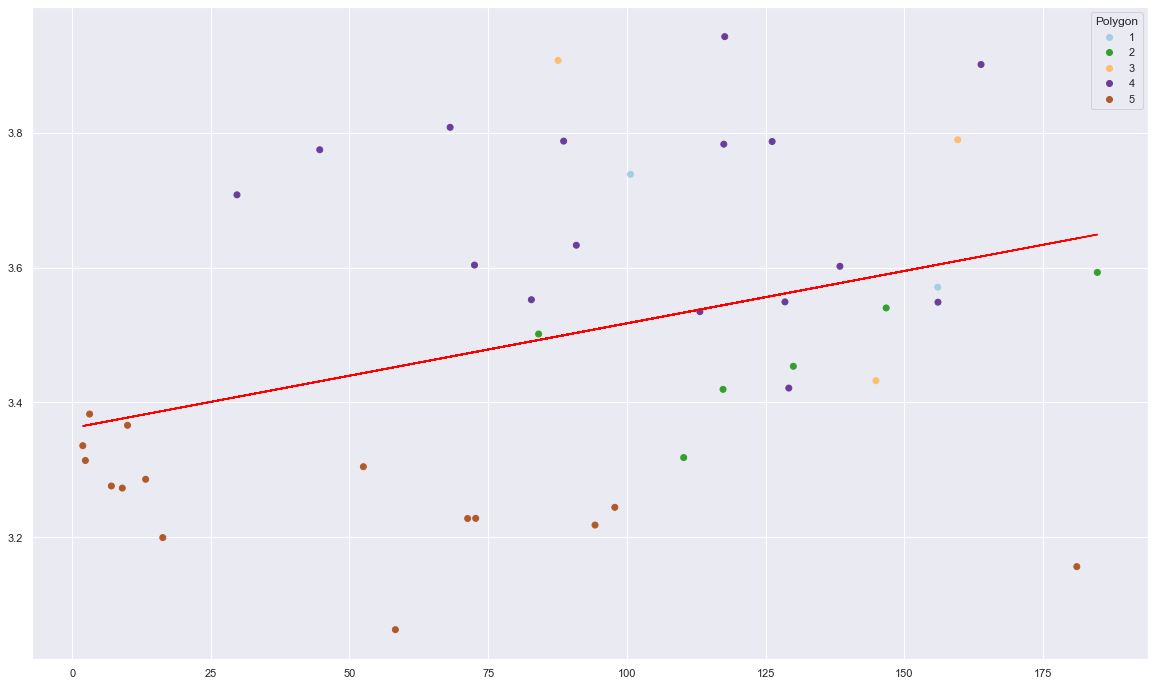

In [361]:
plot_lin_reg(amazon_polygons[(amazon_polygons.water_deficit)].dropna(), 'precipitation', 'pai_interpolated', 'polygon_id')